#1 Hierarchical Reinforcement Learning

For this assignment, we will be referring to Sutton, Precup and Singh’s 1999 paper, ‘Between MDPs and semi-MDPs : A Framework for Temporal Abstraction in Reinforcement Learning’. Please read the paper upto and including Section 3, it is self explanatory and a
good reference leading up to the understanding and implementation of SMDP Q-learning. Section 3 of the paper talks about SMDP planning and is necessary to build intuition to solve this assignment. We will be working with a simple taxi domain environment (explained
in the next section). Your tasks are to implement 1-step SMDP Q-Learning and intra-option Q-Learning on this environment.

#2 Environment Description
The environment for this task is the taxi domain, illustrated in Fig. 1. It is a 5x5 matrix, where each cell is a position your taxi can stay at. There is a single passenger who can be either picked up or dropped off, or is being transported. There are four designated
locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger’s location, picks up the passenger, drives to the
passenger’s destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends.


There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations. Note that there are 400 states that can actually be reached during an episode. The missing states correspond to situations in which the passenger is at the same location as their destination, as this typically signals the end of an episode. Four additional states can be observed right after a successful episodes, when both the passenger and the taxi are at the destination. This gives a total of 404 reachable discrete states.


Passenger locations: 0: R(ed); 1: G(reen); 2: Y(ellow); 3: B(lue); 4: in taxi Destinations: 0: R(ed); 1: G(reen); 2: Y(ellow); 3: B(lue)
Rewards:
 - -1 per step unless other reward is triggered.
 -  +20 delivering passenger.
 - -10 executing ”pickup” and ”drop-off” actions illegally.
The discount factor is taken to be γ = 0.9.

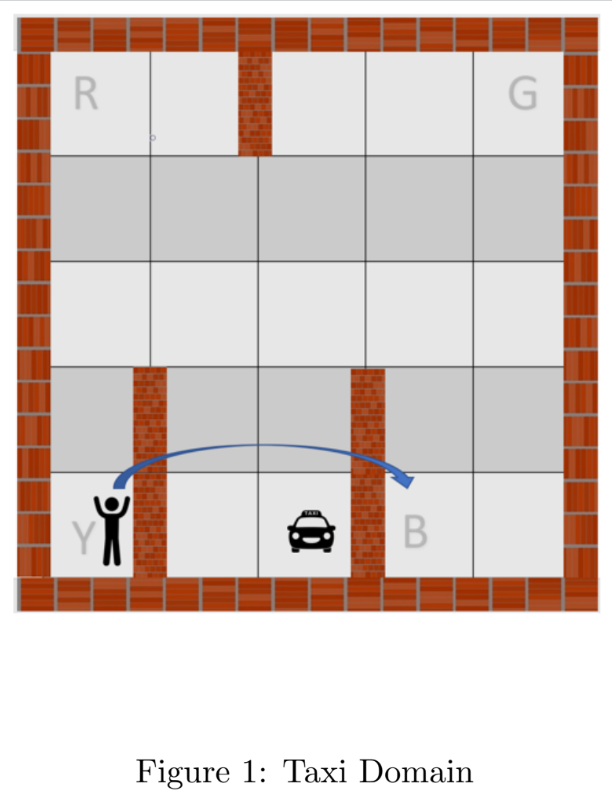

#3 Actions and Options
**Actions:** There are 6 discrete deterministic actions: 0: move south; 1: move north; 2: move east; 3: move west; 4: pick passenger up; and 5: drop passenger off.


**Options:** Options to move the taxi to each of the four designated locations, executable when the taxi is not already there.


You will be experimenting with OpenAI Gym’s Taxi-v3 environment.

# 4 Tasks
First, implement the single step **SMDP Q-learning** for solving the taxi problem. A rough sketch of the algorithm is as follows: Given the set of options,

- Execute the current selected option to termination (e.g. use epsilon greedy $Q(s, o))$.
- Computer $r(s, o)$.
- Update $Q(st, o)$.

Second, implement **intra-option Q-Learning** on the same environment.


For each algorithm, do the following (only for the configuration with the best hyperparameters):

1. Plot reward curves and visualize the learned Q-values.
2. Provide a written description of the policies learnt and your reasoning behind why
the respective algorithm learns the policy.

3. Is there an alternate set of options that you can use to solve this problem, such that this set and the given options to move the taxi are mutually exclusive? If so, run both algorithms with this alternate set of options and compare performance with the algorithms run on the options to move the taxi.


Finally, provide a comparison between the SMDP Q-Learning and intra-option Q-Learning algorithms. Do you observe any improvement with intra-option Q-Learning? If so, describe why this happens as well. Please make sure that all descriptions are brief and to the point.

# 5 Submission Instructions
You are required to submit both your report and your code. Zip your code (a colab/jupyter notebook ipynb file) and report (a pdf file) together and submit.

# Hierarchical RL methods with navigation options

In [ ]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing as mp
from functools import partial
from tqdm import tqdm
import itertools

env = gym.make('Taxi-v3')
num_actions = env.action_space.n
num_rows = 5
num_columns = 5
num_passenger_states = 5
num_destinations = 4

# Hyperparametrs
alpha_values = [0.1, 0.5, 1]
epsilon_values = [0.01, 0.1, 0.5, 1.0]
discount_factor = 0.9 # given

num_agents = 50

class HierarchicalRLAgent:
    """A class implementing hierarchical reinforcement learning methods for the Taxi environment."""

    def __init__(self, env, num_options=4):
        """Initialize the hierarchical reinforcement learning agent.

        Args:
            env: The environment to interact with
            num_options: The number of options to consider
        """
        # Environment parameters
        self.env = env
        self.grid_size_x = num_rows
        self.grid_size_y = num_columns
        self.num_passenger_states = num_passenger_states
        self.num_destinations = num_destinations
        self.num_options = num_options
        self.num_actions = num_actions

        # Training parameter
        self.discount_factor = discount_factor

        # Goal locations for each option (R, G, Y, B)
        self.goals = {0: [0, 0], 1: [0, 4], 2: [4, 0], 3: [4, 3]}

    def get_substate_index(self, state):
        """Convert state to a substate index based on passenger and destination."""
        _, _, passenger, destination = self.env.unwrapped.decode(state)
        return self.num_destinations * passenger + destination

    def epsilon_greedy_policy(self, q_values, state, epsilon):
        """Select an action using epsilon-greedy policy."""
        if np.random.random() < epsilon:
          return np.random.choice(len(q_values[state]))
        else:
          return np.argmax(q_values[state])

    def execute_option(self, state, option, epsilon, option_q_values):
        """Execute an option until termination."""
        option_terminated = 0
        action = None
        x, y, passenger, destination = self.env.unwrapped.decode(state)

        if x == self.goals[option][0] and y == self.goals[option][1]:
            option_terminated = 1
            if passenger == option:
                action = 4  # Pickup
            else:
                action = 5  # Dropoff
        if action is None:
          grid_position = self.grid_size_x * x + y
          action = self.epsilon_greedy_policy(
              option_q_values[option], grid_position, epsilon
          )

        return action, option_terminated

## Reward Curve plotting

In [ ]:
def plot_reward_curve(rewards, title="Rewards Curve"):
    """Plot the learning curve based on rewards."""
    plt.figure(figsize=(10, 5))

    # Plot rewards
    plt.plot(rewards)

    # Set labels and title
    plt.xlabel('Episodes')
    plt.ylabel(f'Total rewards(averaged over {num_agents} agents)')
    plt.title(title)

    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Steps per episodes plotting

In [ ]:
def plot_step_curve(steps, title="Steps Curve"):
    """Plot the learning curve based on steps."""
    plt.figure(figsize=(10, 5))

    # Plot steps
    plt.plot(steps)

    # Set labels and title
    plt.xlabel('Episodes')
    plt.ylabel(f'Total Steps(averaged over {num_agents} agents)')
    plt.title(title)

    plt.show()

## Overall policy plotting

In [ ]:
def visualize_overall_policy(q_values, title="Overall Policy"):
    """Visualize the overall policy as a heatmap with option labels and Q-values."""
    # Get the best option and q-value for each state
    best_options = np.argmax(q_values, axis=1).reshape(num_passenger_states, num_destinations)
    best_options_q_value = np.max(q_values, axis=1).reshape(num_passenger_states, num_destinations)

    # Create labels for options
    option_labels = {0: 'R', 1: 'G', 2: 'Y', 3: 'B'}

    # Define colors for different options
    option_colors = {
        0: 'red',      # Go to R
        1: 'green',    # Go to G
        2: 'gold',     # Go to Y
        3: 'blue'      # Go to B
    }

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 10))

    # Create heatmap
    heatmap = sns.heatmap(
        best_options_q_value,
        xticklabels=["R", "G", "Y", "B"],
        yticklabels=['R', 'G', 'Y', 'B', 'Taxi'],
        annot=False,
        cmap="YlGn",
        cbar_kws={'label': 'Q-value'}
    )

    # Add text annotations with both option and Q-value
    for i in range(num_passenger_states):
        for j in range(num_destinations):
            option = best_options[i, j]
            q_value = best_options_q_value[i, j]

            # Create annotation text with option and Q-value
            text = f"Go to {option_labels[option]}\n{q_value:.2f}"

            # Add text annotation with color based on option
            ax.text(j + 0.5, i + 0.5, text,
                  ha="center", va="center",
                  color=option_colors[option],
                  fontweight='bold',
                  bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    # Set labels and title
    ax.set_xlabel('Destination (Drop-off point)', fontsize=12)
    ax.set_ylabel("Passenger Location", fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')

    # Add a legend for option colors
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                label=f"Go to {option_labels[o]}",
                                markerfacecolor=color, markersize=10)
                      for o, color in option_colors.items()]
    ax.legend(handles=legend_elements, loc='upper right',
            bbox_to_anchor=(1.3, 1.0), title="Options")

    plt.tight_layout()
    plt.show()

## Option policy plotting

In [ ]:
def visualize_option_policies(option_q_values, title_prefix="Policy learned"):
      """Visualize the policies for each option with both action labels and Q-values."""
      fig, axes = plt.subplots(2, 2, figsize=(14, 14))

      # Movement direction labels
      action_labels = {0: 'S', 1: 'N', 2: 'E', 3: 'W', 4: 'P', 5: 'D'}
      option_labels = {0: 'go to R', 1: 'go to G', 2: 'go to Y', 3: 'go to B'}

      # Define colors for different actions
      action_colors = {
          0: 'red',      # South
          1: 'green',    # North
          2: 'blue',     # East
          3: 'purple',   # West
          4: 'orange',   # Pickup
          5: 'brown'     # Dropoff
      }

      # Plot each option's policy
      for i in range(2):
          for j in range(2):
              option_idx = 2 * i + j

              # Get best actions and Q-values for each grid position
              best_actions = np.argmax(option_q_values[option_idx], axis=1).reshape(num_rows, num_columns)
              best_q_values = np.max(option_q_values[option_idx], axis=1).reshape(num_rows, num_columns)

              # Create heatmap
              ax = axes[i, j]
              heatmap = sns.heatmap(
                  best_q_values,
                  ax=ax,
                  cmap="YlGn",
                  cbar_kws={'label': 'Q-value'},
                  annot=False
              )

              # Add text annotations with both action and Q-value
              for x in range(num_rows):
                  for y in range(num_columns):
                      action = best_actions[x, y]
                      q_value = best_q_values[x, y]

                      # Create annotation text with action and Q-value
                      text = f"{action_labels[action]}\n{q_value:.2f}"

                      # Add text annotation with color based on action
                      ax.text(y + 0.5, x + 0.5, text,
                            ha="center", va="center",
                            color=action_colors[action],
                            fontweight='bold',
                            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

              # Set title and labels
              ax.set_title(f"{title_prefix} for Option {option_labels[option_idx]}")
              ax.set_xlabel("Column")
              ax.set_ylabel("Row")

      legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                  label=f"{action_labels[a]}: {['South', 'North', 'East', 'West', 'Pickup', 'Dropoff'][a]}",
                                  markerfacecolor=color, markersize=10)
                        for a, color in action_colors.items()]
      fig.legend(handles=legend_elements, loc='lower center',ncol=len(action_colors), title="Actions")

      plt.tight_layout()
      plt.subplots_adjust(bottom=0.1)
      plt.show()

## Rewards curve comparison plotting

In [ ]:
def plot_reward_curves_comparison(results_dict, window_size=100, episode_range="all",
                      title="Rewards Comparison of Hierarchical RL Methods"):
    """
    Plot reward curves for different RL methods with flexibility to select episode ranges.
    """
    fig = plt.figure(figsize=(10, 5))

    # Store data for all methods to determine x-axis range
    all_avg_rewards = []

    # Calculate moving averages for each method
    for method_name, results in results_dict.items():
        rewards = results["rewards_per_episode"]
        total_episodes = len(rewards)

        # Calculate moving average
        avg_rewards = [np.average(rewards[i:i+window_size])
                      for i in range(total_episodes - window_size + 1)]
        all_avg_rewards.append(avg_rewards)

    # Determine episode range to plot
    max_length = max(len(avg) for avg in all_avg_rewards)

    if episode_range == "all":
        start_idx, end_idx = 0, max_length
    elif episode_range == f"first_{window_size}":
        start_idx, end_idx = 0, min(window_size, max_length)
    elif episode_range == f"last_{window_size}":
        start_idx = max(0, max_length - window_size)
        end_idx = max_length
    elif isinstance(episode_range, tuple) and len(episode_range) == 2:
        start_idx = max(0, min(episode_range[0], max_length))
        end_idx = min(episode_range[1], max_length)
    else:
        raise ValueError("Invalid episode_range. Use 'all', 'first_n', 'last_n', or (start, end) tuple.")

    # Plot each method's reward curve
    for i, (method_name, results) in enumerate(results_dict.items()):
        avg_rewards = all_avg_rewards[i]
        selected_rewards = avg_rewards[start_idx:end_idx]

        # Create x-axis values based on the range
        x_values = range(start_idx, start_idx + len(selected_rewards))

        # Plot with method name and hyperparameters in label
        label = f'{method_name} (α={results["learning_rate"]}, ε={results["epsilon"]})'
        plt.plot(x_values, selected_rewards, label=label)

    # Add plot details
    plt.xlabel('Episodes')
    plt.ylabel(f'Score averaged over previous {window_size} runs')
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.show()

## Steps curve comparison plotting

In [ ]:
def plot_step_curves_comparison(results_dict, window_size=100, episode_range="all",
                      title="Steps Comparison of Hierarchical RL Methods"):
    """
    Plot step curves for different RL methods with flexibility to select episode ranges.
    """
    fig = plt.figure(figsize=(10, 5))

    # Store data for all methods to determine x-axis range
    all_avg_steps = []

    # Calculate moving averages for each method
    for method_name, results in results_dict.items():
        steps = results["steps_per_episode"]
        total_episodes = len(steps)

        # Calculate moving average
        avg_steps = [np.average(steps[i:i+window_size])
                      for i in range(total_episodes - window_size + 1)]
        all_avg_steps.append(avg_steps)

    # Determine episode range to plot
    max_length = max(len(avg) for avg in all_avg_steps)

    if episode_range == "all":
        start_idx, end_idx = 0, max_length
    elif episode_range == f"first_{window_size}":
        start_idx, end_idx = 0, min(window_size, max_length)
    elif episode_range == f"last_{window_size}":
        start_idx = max(0, max_length - window_size)
        end_idx = max_length
    elif isinstance(episode_range, tuple) and len(episode_range) == 2:
        start_idx = max(0, min(episode_range[0], max_length))
        end_idx = min(episode_range[1], max_length)
    else:
        raise ValueError("Invalid episode_range. Use 'all', 'first_n', 'last_n', or (start, end) tuple.")

    # Plot each method's step curve
    for i, (method_name, results) in enumerate(results_dict.items()):
        avg_steps = all_avg_steps[i]
        selected_steps = avg_steps[start_idx:end_idx]

        # Create x-axis values based on the range
        x_values = range(start_idx, start_idx + len(selected_steps))

        # Plot with method name and hyperparameters in label
        label = f'{method_name} (α={results["learning_rate"]}, ε={results["epsilon"]})'
        plt.plot(x_values, selected_steps, label=label)

    # Add plot details
    plt.xlabel('Episodes')
    plt.ylabel(f'Steps averaged over previous {window_size} runs')
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.show()

## Hyperparameter tuning

In [ ]:
class HyperparameterTuner:
    """A class for tuning hyperparameters of the HierarchicalRLAgent with parallel processing."""

    def __init__(self, num_agents=5, num_episodes=1000, agent_class=None, n_processes=None):
        """Initialize the hyperparameter tuner.

        Args:
            num_agents: Number of agents to use for each hyperparameter configuration
            num_episodes: Number of episodes to train each agent
            agent_class: Class to use for creating the agents
            n_processes: Number of processes to use for parallelization
        """
        self.num_agents = num_agents
        self.num_episodes = num_episodes
        self.agent_class = agent_class if agent_class is not None else HierarchicalRLAgent

        # Default to the number of CPU cores if n_processes is not specified
        self.n_processes = n_processes if n_processes is not None else mp.cpu_count()

    def train_single_combination(self, params, method='smdp'):
        """Train agents for a single hyperparameter combination.

        Args:
            params: Tuple of (alpha, epsilon) hyperparameters
            method: Training method ('smdp' or 'ioql')

        Returns:
            Dictionary with results for this configuration
        """
        alpha, epsilon = params

        # Training different agents to deal with the stochasticity
        Q_per_agents = []
        rewards_per_episode_per_agents = []
        steps_per_episode_per_agents = []
        option_Q_per_agents = []

        for _ in range(self.num_agents):
            env = gym.make('Taxi-v3')
            agent = self.agent_class(env)

            if self.agent_class == HierarchicalRLAgent:
                # Train the agent using the specified method
                if method == 'smdp':
                    episode_rewards, q_values, steps, option_q_values = train_smdp_q_learning(
                        hrl_obj=agent,
                        learning_rate=alpha,
                        epsilon=epsilon,
                        num_episodes=self.num_episodes
                    )
                else:
                    episode_rewards, q_values, steps, option_q_values = train_intra_option_q_learning(
                        hrl_obj=agent,
                        learning_rate=alpha,
                        epsilon=epsilon,
                        num_episodes=self.num_episodes
                    )
            else:
                # Train the agent using the specified method
                if method == 'smdp':
                    episode_rewards, q_values, steps, option_q_values = train_smdp_q_learning_modified(
                        hrl_obj=agent,
                        learning_rate=alpha,
                        epsilon=epsilon,
                        num_episodes=self.num_episodes
                    )
                else:
                    episode_rewards, q_values, steps, option_q_values = train_smdp_q_learning_modified(
                        hrl_obj=agent,
                        learning_rate=alpha,
                        epsilon=epsilon,
                        num_episodes=self.num_episodes
                    )

            Q_per_agents.append(q_values)
            rewards_per_episode_per_agents.append(episode_rewards)
            steps_per_episode_per_agents.append(steps)
            option_Q_per_agents.append(option_q_values)

        # Average across agents
        Q = np.mean(Q_per_agents, axis=0)
        rewards_per_episode = np.mean(rewards_per_episode_per_agents, axis=0)
        steps_per_episode = np.mean(steps_per_episode_per_agents, axis=0)
        option_Q = np.mean(option_Q_per_agents, axis=0)

        # Average for finding the best hyperparameter
        mean_reward = np.mean(rewards_per_episode)
        std_reward = np.std(rewards_per_episode)

        return {
            'learning_rate': alpha,
            'epsilon': epsilon,
            'mean_reward': mean_reward,
            'std_reward': std_reward,
            'Q': Q,
            'rewards_per_episode': rewards_per_episode,
            'steps_per_episode': steps_per_episode,
            'option_Q': option_Q
        }

    def tune_hyperparameters(self, alpha_values, epsilon_values, method='smdp'):
        """Tune hyperparameters by training multiple agents with different configurations in parallel.

        Args:
            alpha_values: List of learning rate values to try
            epsilon_values: List of epsilon values to try
            method: Training method to use ('smdp' or 'ioql')

        Returns:
            best_params: Dictionary with best hyperparameter values
        """
        # Create all parameter combinations
        param_combinations = list(itertools.product(alpha_values, epsilon_values))
        total_combinations = len(param_combinations)

        # Create a partial function with fixed arguments
        train_func = partial(
            self.train_single_combination,
            method=method
        )

        # Run in parallel
        print(f"Running {total_combinations} hyperparameter combinations on {self.n_processes} processes...")
        with mp.Pool(processes=self.n_processes) as pool:
            results = list(tqdm(
                pool.imap(train_func, param_combinations),
                total=total_combinations,
                desc="Testing hyperparameters"
            ))

        # Sort results by mean reward (descending)
        results.sort(key=lambda x: x['mean_reward'], reverse=True)

        return results[0]

# SMDP Q-learning

In [ ]:
def train_smdp_q_learning(hrl_obj, epsilon, learning_rate, num_episodes):
      """Train using SMDP Q-learning."""
      episode_rewards = []
      smdp_q_values = np.zeros((hrl_obj.num_passenger_states * hrl_obj.num_destinations, hrl_obj.num_options))
      smdp_steps = np.zeros(num_episodes)
      option_q_values = [np.zeros((hrl_obj.grid_size_x * hrl_obj.grid_size_y, hrl_obj.num_actions))
            for _ in range(hrl_obj.num_options)
      ]

      for episode in range(num_episodes):
          state, _ = hrl_obj.env.reset()
          done = False
          total_reward = 0

          while not done:
              # Choose option using epsilon-greedy
              substate = hrl_obj.get_substate_index(state)
              selected_option = hrl_obj.epsilon_greedy_policy(
                  smdp_q_values, substate, epsilon
              )

              # Track previous state for Q-value update
              previous_state = state
              previous_substate = substate

              # Execute the selected option
              cumulative_reward = 0
              option_terminated = False
              steps_taken_in_option = 0

              while not option_terminated and not done:
                  # Get action from option policy
                  action, option_terminated = hrl_obj.execute_option(
                      state, selected_option, epsilon, option_q_values
                  )

                  # Execute action in environment
                  next_state, reward, terminated, truncated, _ = hrl_obj.env.step(action)
                  done = terminated or truncated

                  # Decode the states
                  old_x, old_y, _, _ = hrl_obj.env.unwrapped.decode(state)
                  new_x, new_y, _, _ = hrl_obj.env.unwrapped.decode(next_state)

                  # Calculate grid positions
                  old_grid_pos = hrl_obj.grid_size_x * old_x + old_y
                  new_grid_pos = hrl_obj.grid_size_x * new_x + new_y

                  # If the old_grid_pos is not a terminating position for the option, then update option policy's Q-values
                  if not option_terminated:
                    current_q = option_q_values[selected_option][old_grid_pos, action]
                    max_next_q = np.max(option_q_values[selected_option][new_grid_pos, :])
                    target = reward + hrl_obj.discount_factor * max_next_q
                    option_q_values[selected_option][old_grid_pos, action] += learning_rate * (target - current_q)

                  # Accumulate rewards and track steps
                  cumulative_reward = hrl_obj.discount_factor * cumulative_reward + reward
                  total_reward += reward
                  steps_taken_in_option += 1
                  state = next_state

              new_substate = hrl_obj.get_substate_index(state)

              # Update SMDP Q-value after option execution
              current_q = smdp_q_values[previous_substate, selected_option]
              max_next_q = np.max(smdp_q_values[new_substate, :])
              target = cumulative_reward + (hrl_obj.discount_factor ** steps_taken_in_option) * max_next_q
              smdp_q_values[previous_substate, selected_option] += learning_rate * (target - current_q)

              # Track steps for analysis
              smdp_steps[episode] += steps_taken_in_option

          # Record episode rewards
          episode_rewards.append(total_reward)

      return episode_rewards, smdp_q_values, smdp_steps, option_q_values

In [ ]:
# Create tuner
tuner = HyperparameterTuner(num_agents=num_agents, num_episodes=1000)

# Tune SMDP Q-learning hyperparameters
print("Tuning hyperparameters for SMDP Q-learning...")
smdp_tuning_results = tuner.tune_hyperparameters(
    alpha_values, epsilon_values, method='smdp'
)
print(f'\nBest SMDP learning rate: {smdp_tuning_results["learning_rate"]}')
print(f'Best SMDP Epsilon(exploration parameter): {smdp_tuning_results["epsilon"]}')
print('Mean reward using best hyperparameters:', smdp_tuning_results['mean_reward'])
print('Standard deviation of reward using best hyperparameters:', smdp_tuning_results['std_reward'])

Tuning hyperparameters for SMDP Q-learning...
Running 12 hyperparameter combinations on 4 processes...


Testing hyperparameters: 100%|██████████| 12/12 [20:33<00:00, 102.78s/it]


Best SMDP learning rate: 0.5
Best SMDP Epsilon(exploration parameter): 0.01
Mean reward using best hyperparameters: -0.6940400000000004
Standard deviation of reward using best hyperparameters: 42.41366974547711


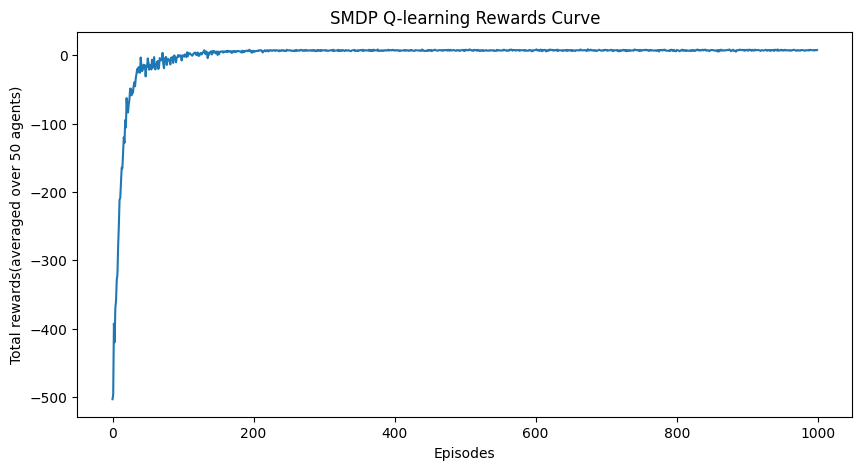

In [ ]:
# Plotting Rewards per Episode during Training(averaged over all the agents)
plot_reward_curve(smdp_tuning_results["rewards_per_episode"], "SMDP Q-learning Rewards Curve")

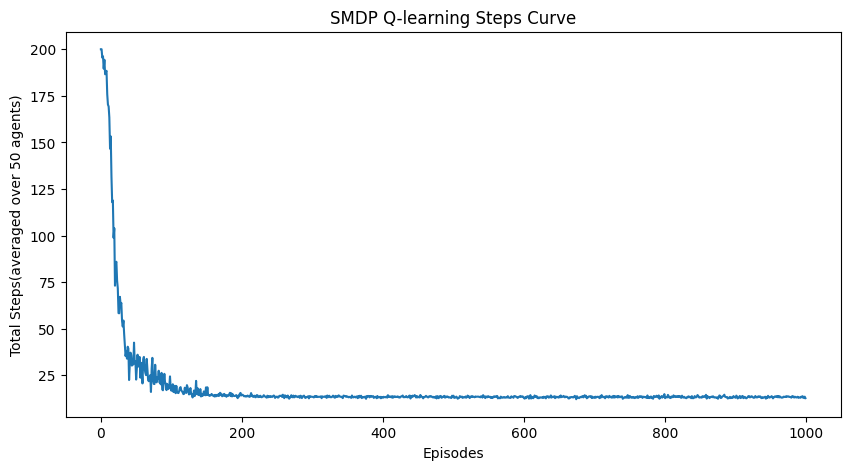

In [ ]:
# Plotting Steps per Episode during Training(averaged over all the agents)
plot_step_curve(smdp_tuning_results["steps_per_episode"], "SMDP Q-learning Steps Curve")

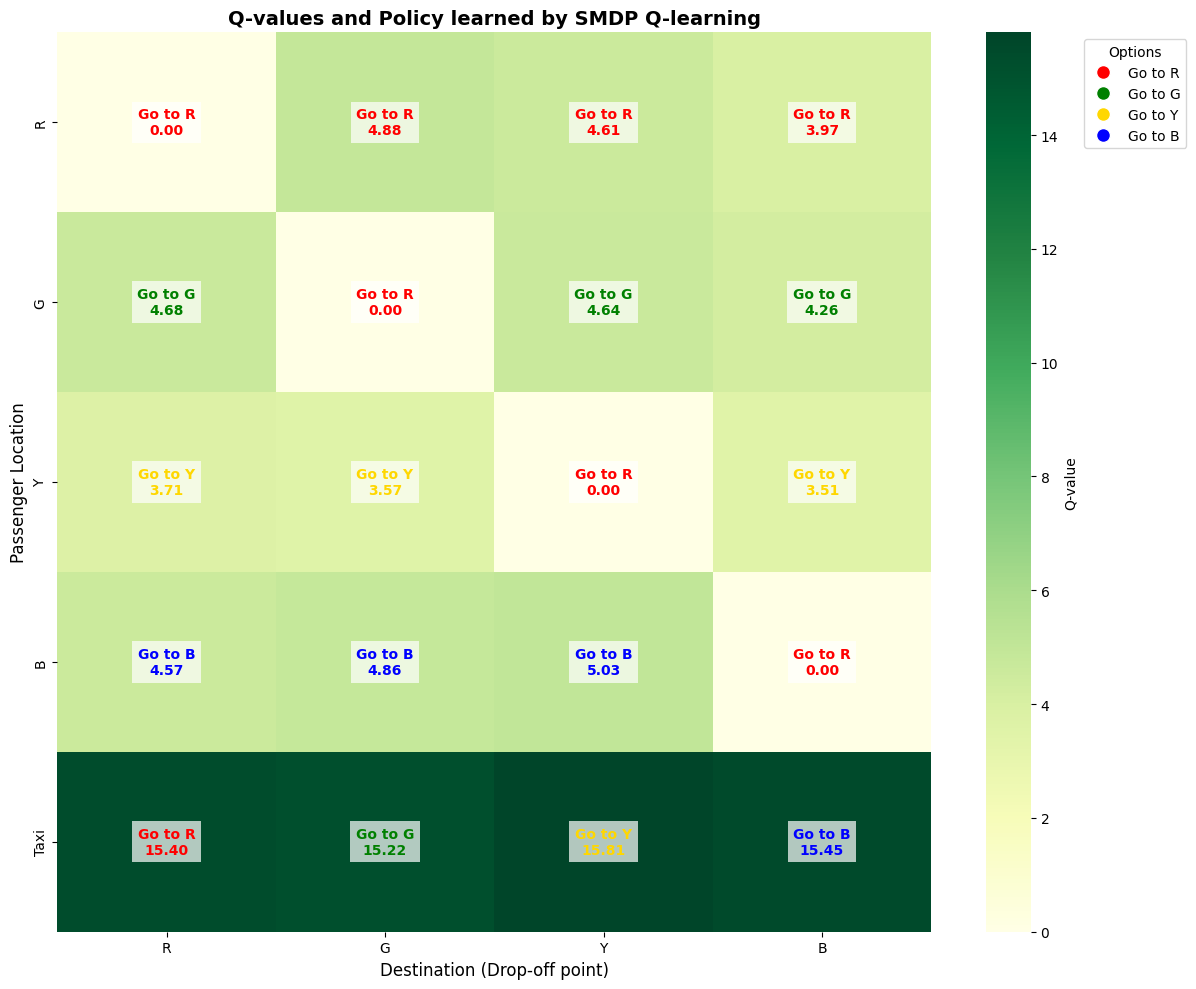

In [ ]:
# Plotting the Maximum Q-values After Training (averaged over all the agents)
visualize_overall_policy(smdp_tuning_results["Q"], "Q-values and Policy learned by SMDP Q-learning")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


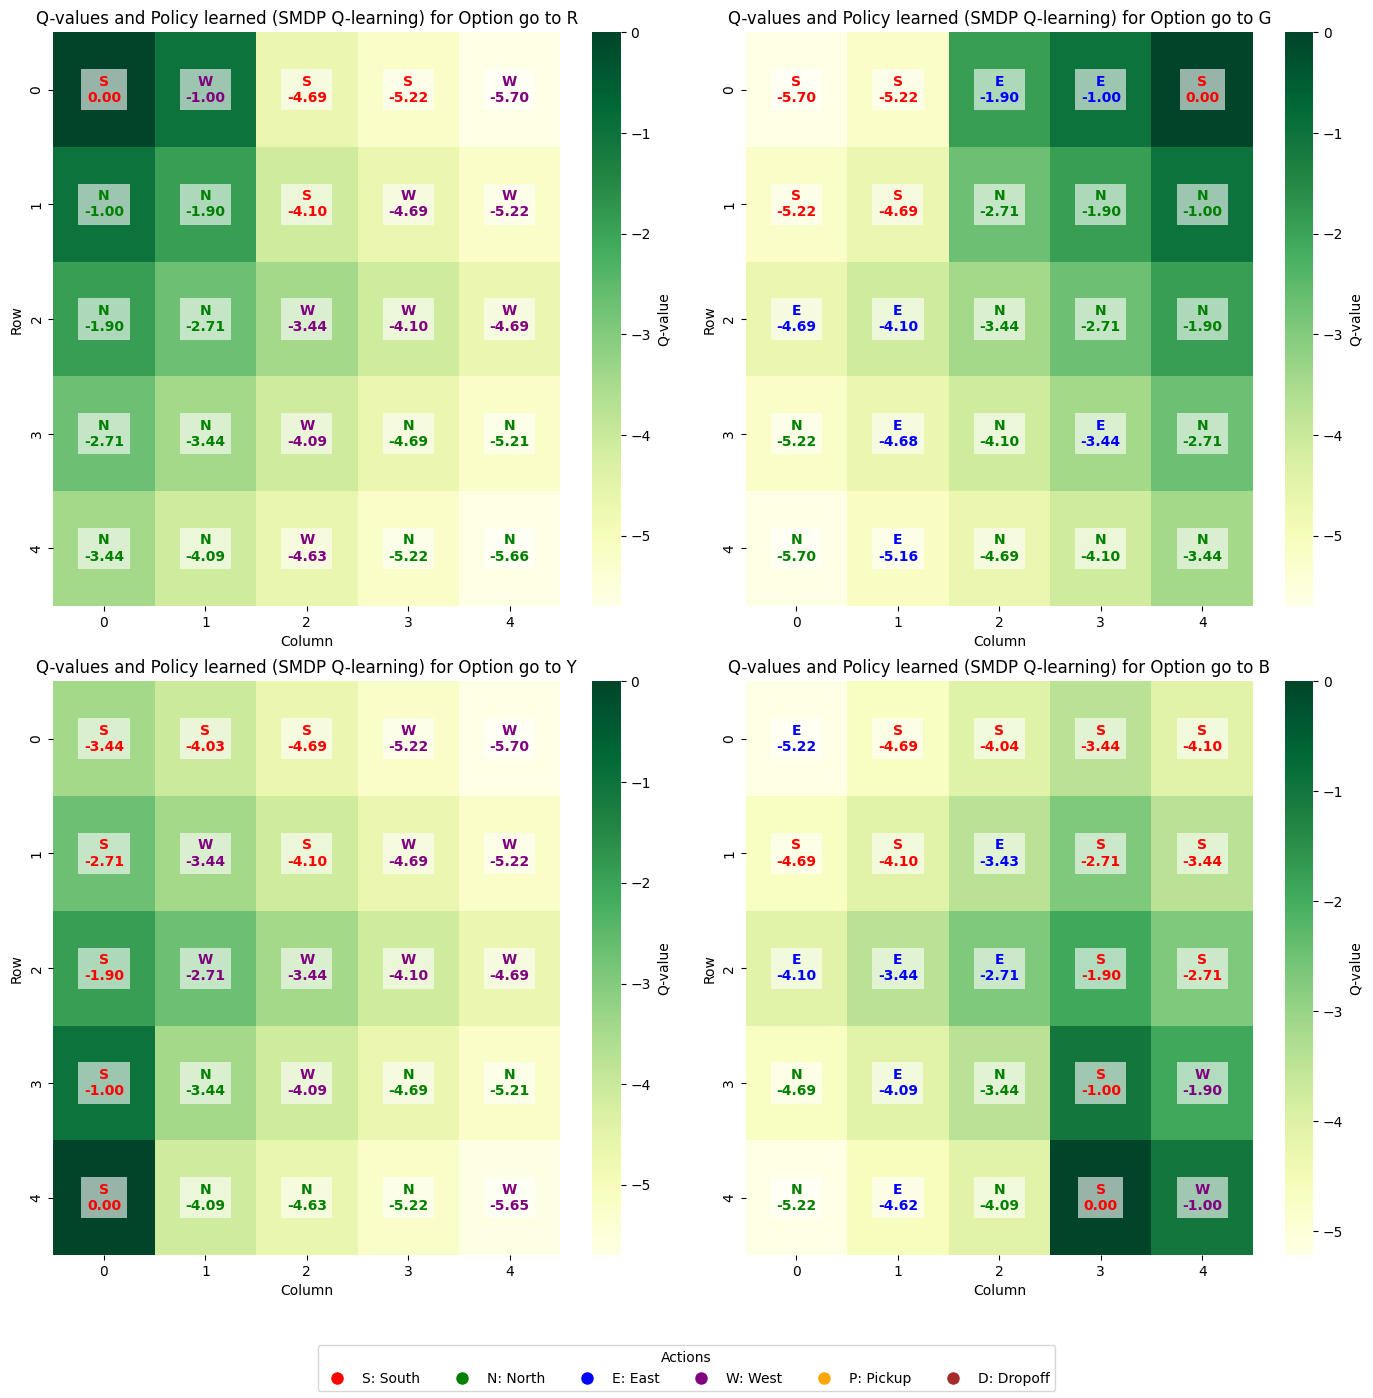

In [ ]:
# Plotting the Maximum Q-values of Each Option After Training (averaged over all the agents)
visualize_option_policies(smdp_tuning_results["option_Q"], "Q-values and Policy learned (SMDP Q-learning)")

# Intra-Option Q-learning

In [ ]:
def train_intra_option_q_learning(hrl_obj, epsilon, learning_rate, num_episodes):
        """Train using Intra-Option Q-learning."""
        episode_rewards = []
        ioql_steps = []

        # Initialize Q-values for intra-option learning
        intra_option_q_values = np.zeros((hrl_obj.num_passenger_states * hrl_obj.num_destinations, hrl_obj.num_options))
        option_q_values = [np.zeros((hrl_obj.grid_size_x * hrl_obj.grid_size_y, hrl_obj.num_actions))
            for _ in range(hrl_obj.num_options)]

        for episode in range(num_episodes):
            state, _ = hrl_obj.env.reset()
            done = False
            total_reward = 0
            total_steps = 0

            while not done:
                # Choose option using epsilon-greedy
                substate = hrl_obj.get_substate_index(state)
                selected_option = hrl_obj.epsilon_greedy_policy(
                    intra_option_q_values, substate, epsilon
                )

                option_terminated = False

                while not option_terminated and not done:
                    # Get action from option policy
                    action, option_terminated = hrl_obj.execute_option(
                        state, selected_option, epsilon, option_q_values
                    )

                    # Execute action in environment
                    next_state, reward, terminated, truncated, _ = hrl_obj.env.step(action)
                    done = terminated or truncated
                    total_reward += reward
                    total_steps += 1

                    # Decode the states
                    x, y, _, _ = hrl_obj.env.unwrapped.decode(state)
                    next_x, next_y, _, _ = hrl_obj.env.unwrapped.decode(next_state)

                    # Calculate grid positions
                    grid_pos = hrl_obj.grid_size_x * x + y
                    next_grid_pos = hrl_obj.grid_size_x * next_x + next_y

                    # If the grid_pos is not a terminating position for the option, then update option policy's Q-values
                    if not option_terminated:
                      current_q = option_q_values[selected_option][grid_pos, action]
                      max_next_q = np.max(option_q_values[selected_option][next_grid_pos, :])
                      target = reward + hrl_obj.discount_factor *  max_next_q
                      option_q_values[selected_option][grid_pos, action] += learning_rate * (target - current_q)

                    # Update intra-option Q-values for all options that would have taken the same action
                    current_substate = hrl_obj.get_substate_index(state)
                    next_substate = hrl_obj.get_substate_index(next_state)

                    for option_idx in range(hrl_obj.num_options):
                        option_action, option_terminated_here = hrl_obj.execute_option(
                            state, option_idx, epsilon, option_q_values
                        )

                        # If the option_action is consistent with the action taken following the selected_option
                        if option_action == action or option_idx == selected_option:

                            current_q = intra_option_q_values[current_substate, option_idx]

                            if option_terminated_here:
                                # Option termination: bootstrap from best next option
                                max_next_q = np.max(intra_option_q_values[next_substate, :])
                                target = reward + hrl_obj.discount_factor * max_next_q

                            else:
                                # Option continuation: follow current option
                                next_q = intra_option_q_values[next_substate, option_idx]
                                target = reward + hrl_obj.discount_factor * next_q

                            intra_option_q_values[current_substate, option_idx] += learning_rate * (target - current_q)

                    state = next_state

            # Record episode results
            episode_rewards.append(total_reward)
            ioql_steps.append(total_steps)

        return episode_rewards, intra_option_q_values, ioql_steps, option_q_values

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Create tuner
tuner = HyperparameterTuner(num_agents=num_agents, num_episodes=1000)

# Tune Intra-Option Q-learning hyperparameters
print("Tuning hyperparameters for Intra-Option Q-learning...")
ioql_tuning_results = tuner.tune_hyperparameters(
    alpha_values, epsilon_values, method='ioql'
)
print(f'\nBest IOQL learning rate: {ioql_tuning_results["learning_rate"]}')
print(f'Best IOQL Epsilon(exploration parameter): {ioql_tuning_results["epsilon"]}')
print('Mean reward using best hyperparameters:', ioql_tuning_results['mean_reward'])
print('Standard deviation of reward using best hyperparameters:', ioql_tuning_results['std_reward'])

Tuning hyperparameters for Intra-Option Q-learning...
Running 12 hyperparameter combinations on 4 processes...


Testing hyperparameters: 100%|██████████| 12/12 [46:38<00:00, 233.20s/it]


Best IOQL learning rate: 0.5
Best IOQL Epsilon(exploration parameter): 0.01
Mean reward using best hyperparameters: -0.9242199999999994
Standard deviation of reward using best hyperparameters: 42.74644345663859


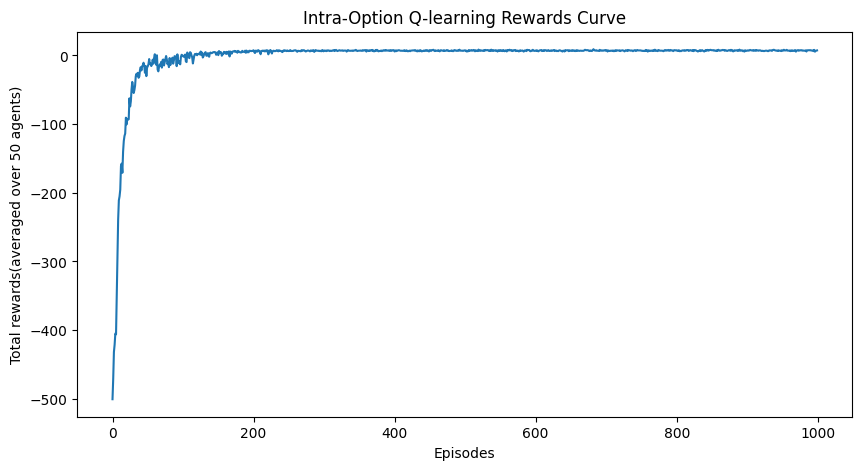

In [ ]:
# Plotting Rewards per Episode during Training(averaged over all the agents)
plot_reward_curve(ioql_tuning_results["rewards_per_episode"], "Intra-Option Q-learning Rewards Curve")

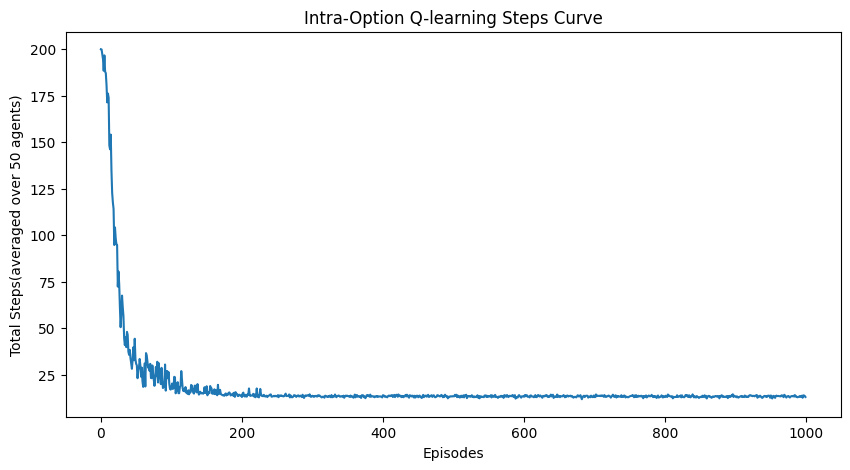

In [ ]:
# Plotting Steps per Episode during Training(averaged over all the agents)
plot_step_curve(ioql_tuning_results["steps_per_episode"], "Intra-Option Q-learning Steps Curve")

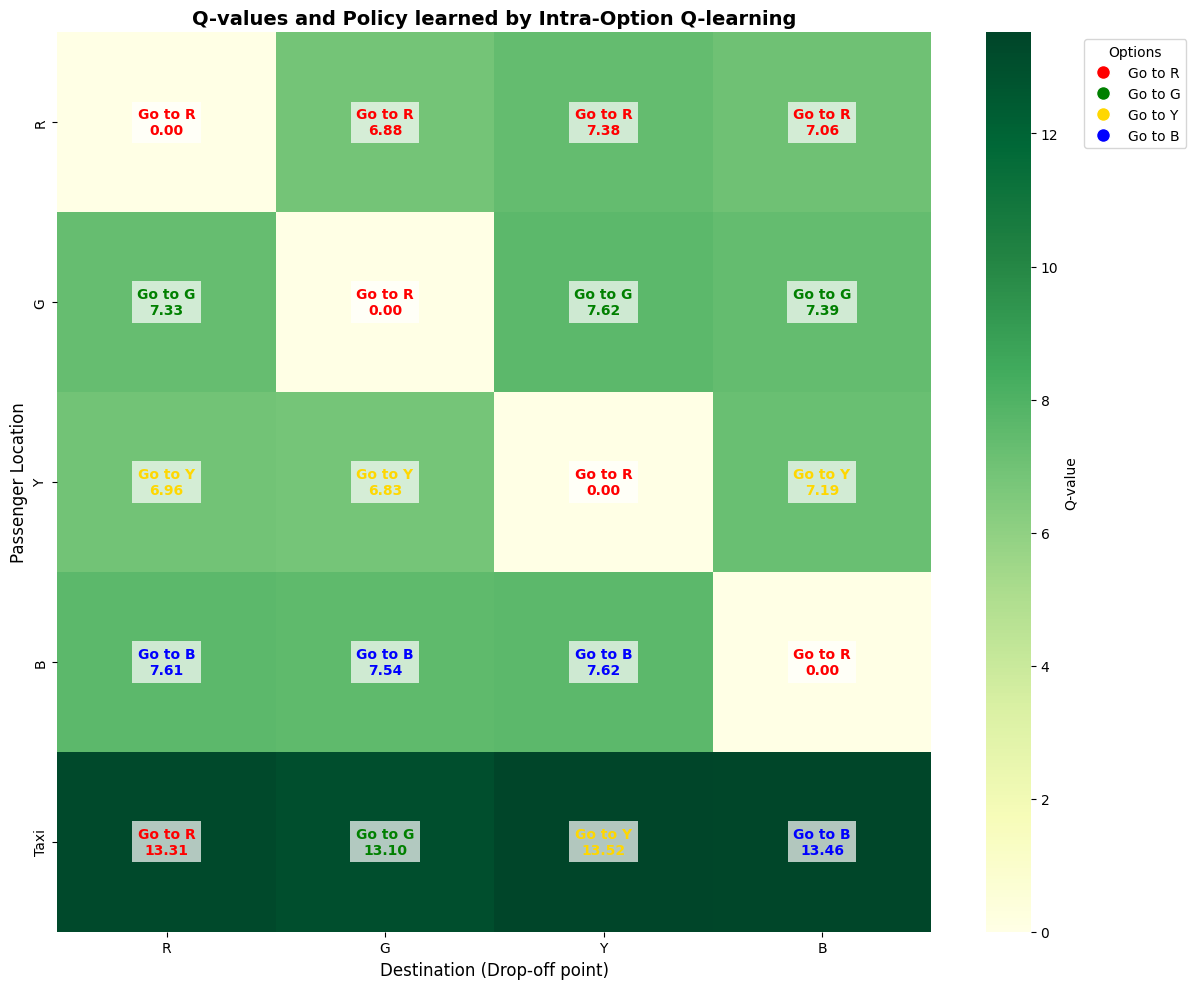

In [ ]:
# Plotting the Maximum Q-values After Training (averaged over all the agents)
visualize_overall_policy(ioql_tuning_results["Q"], "Q-values and Policy learned by Intra-Option Q-learning")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


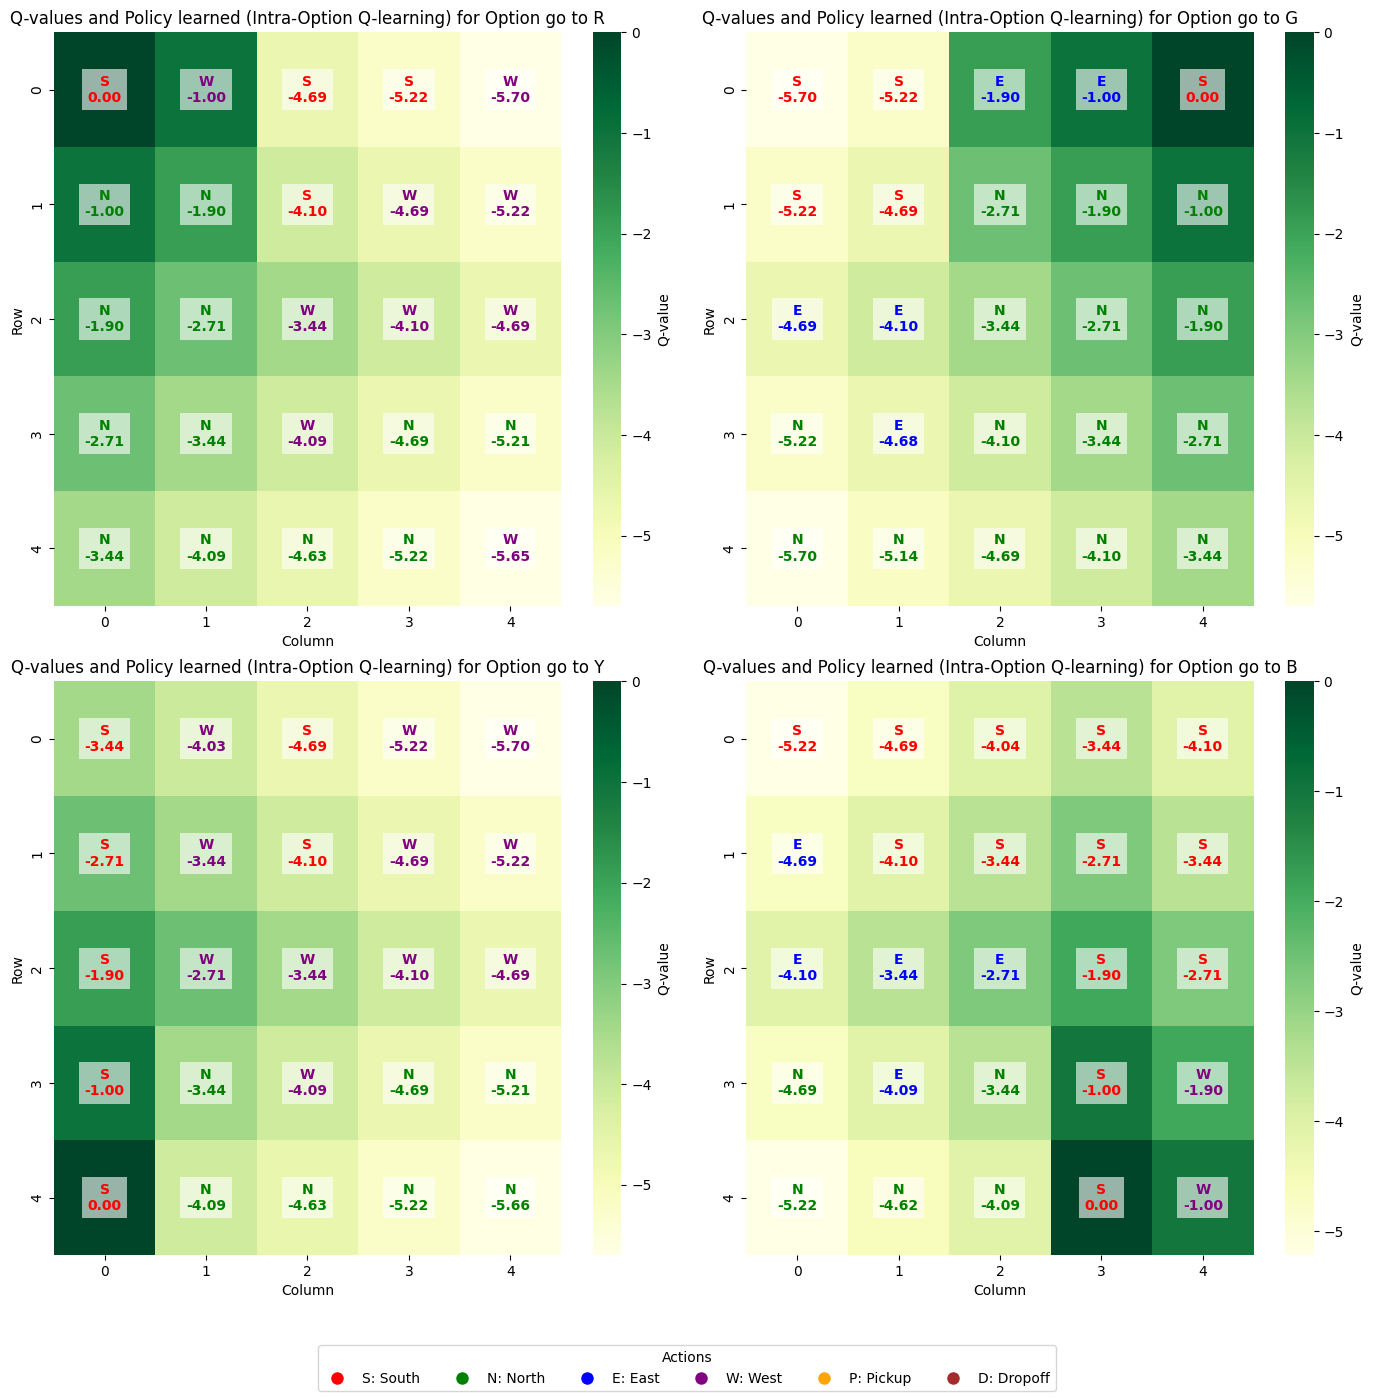

In [ ]:
# Plotting the Maximum Q-values of Each Option After Training (averaged over all the agents)
visualize_option_policies(ioql_tuning_results["option_Q"], "Q-values and Policy learned (Intra-Option Q-learning)")

# Comparison between the two algorithms

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


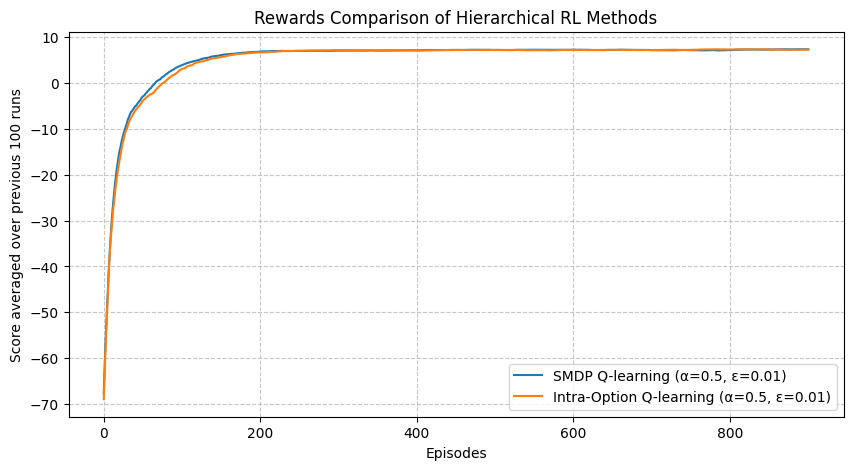

In [ ]:
results_dict = {
    'SMDP Q-learning': smdp_tuning_results,
    'Intra-Option Q-learning': ioql_tuning_results
}
plot_reward_curves_comparison(results_dict)

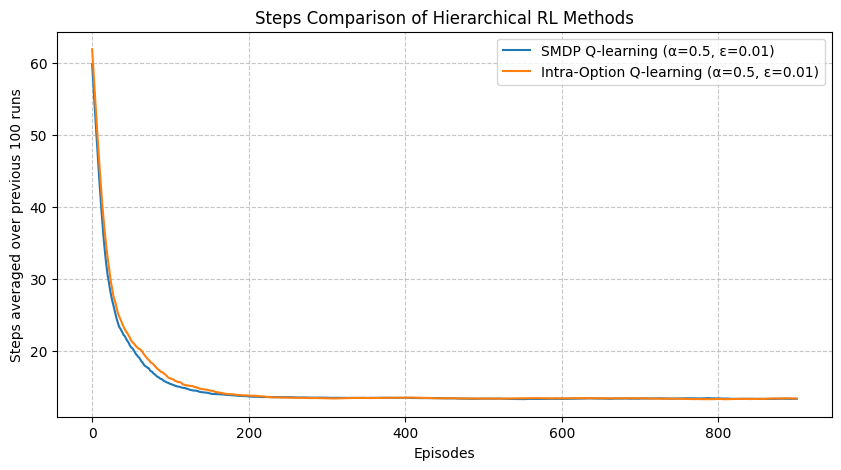

In [ ]:
plot_step_curves_comparison(results_dict)

# Alternate Options (Pickup and Dropoff options)

In [ ]:
# Modified HRL Agent class to handle pickup/dropoff options
class ModifiedOptionsHRLAgent(HierarchicalRLAgent):
    """HRL agent that uses 2 options - pickup and dropoff."""

    def __init__(self, env):
        """Initialize the agent."""
        super().__init__(env, num_options=2)
        self.pickup_locs = {0: [0, 0], 1: [0, 4], 2: [4, 0], 3: [4, 3], 4:[0, 0]} # since 4 represents the passenger is inside taxi, a random grid location is set as pickup location

    def execute_option(self, state, option, epsilon, option_q_values):
        """Execute an option until termination.

        Returns:
            action: The action to take
            option_terminated: Whether the option has terminated
        """
        option_terminated = 0
        action = None
        x, y, passenger, destination = self.env.unwrapped.decode(state)

        # Pickup option
        if option == 0:
            option_state = (self.grid_size_x * x + y) * self.grid_size_y + passenger
            # If taxi is at pickup location
            if x == self.pickup_locs[passenger][0] and y == self.pickup_locs[passenger][1]:
                action = 4  # Pickup action
                option_terminated = 1

        # Dropoff option
        else:
            option_state = (self.grid_size_x * x + y) * self.grid_size_y + destination
            # If taxi is at destination
            if x == self.env.unwrapped.locs[destination][0] and y == self.env.unwrapped.locs[destination][1]:
                action = 5  # Dropoff action
                option_terminated = 1

        if action is None:
            action = self.epsilon_greedy_policy(
                option_q_values[option], option_state, epsilon
            )

        return action, option_terminated

    def get_substate_index(self, state):
        """Use parent method as is"""
        return super().get_substate_index(state)

    def epsilon_greedy_policy(self, q_values, state, epsilon):
        """Use parent method as is"""
        return super().epsilon_greedy_policy(q_values, state, epsilon)

## Overall policy plotting

In [ ]:
def visualize_overall_policy_modified(q_values, title="Overall Policy"):
    """Visualize the overall policy as a heatmap with option labels and Q-values."""
    # Get the best option and q values for each state
    best_options = np.argmax(q_values, axis=1).reshape(num_passenger_states, num_destinations)
    best_options_q_value = np.max(q_values, axis=1).reshape(num_passenger_states, num_destinations)

    # Create labels for options
    option_labels = {0: 'Pickup', 1: 'Dropoff'}

    # Define colors for different options
    option_colors = {
        0: 'red',      # Pickup
        1: 'green',    # Dropoff
    }

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 10))

    # Create heatmap
    heatmap = sns.heatmap(
        best_options_q_value,
        xticklabels=["R", "G", "Y", "B"],
        yticklabels=['R', 'G', 'Y', 'B', 'Taxi'],
        annot=False,
        cmap="YlGn",
        cbar_kws={'label': 'Q-value'}
    )

    # Add text annotations with both option and Q-value
    for i in range(num_passenger_states):
        for j in range(num_destinations):
            option = best_options[i, j]
            q_value = best_options_q_value[i, j]

            # Create annotation text with option and Q-value
            text = f"{option_labels[option]}\n{q_value:.2f}"

            # Add text annotation with color based on option
            ax.text(j + 0.5, i + 0.5, text,
                  ha="center", va="center",
                  color=option_colors[option],
                  fontweight='bold',
                  bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    # Set labels and title
    ax.set_xlabel('Destination (Drop-off point)', fontsize=12)
    ax.set_ylabel("Passenger Location", fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')

    # Add a legend for option colors
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                label=f"{option_labels[o]}",
                                markerfacecolor=color, markersize=10)
                      for o, color in option_colors.items()]
    ax.legend(handles=legend_elements, loc='upper right',
            bbox_to_anchor=(1.3, 1.0), title="Options")

    plt.tight_layout()
    plt.show()

## Option policy plotting

In [ ]:
def visualize_option_q_values_modified(option_q_values, title="Policy learned"):
    """
    Visualize the policies for each option with both action labels and Q-values.
    Creates subplots per option to represent different passenger/destination combinations.
    """

    # Movement direction labels
    action_labels = {0: 'S', 1: 'N', 2: 'E', 3: 'W', 4: 'P', 5: 'D'}
    option_labels = {0: 'Pickup option', 1: 'Dropoff option'}

    # Define colors for different actions
    action_colors = {
        0: 'red',      # South
        1: 'green',    # North
        2: 'blue',     # East
        3: 'purple',   # West
        4: 'orange',   # Pickup
        5: 'brown'     # Dropoff
    }

    num_options = len(option_q_values)

    # Create a single figure to hold all plots
    fig = plt.figure(figsize=(30, 12))

    # Set the main title for the entire figure
    fig.suptitle(title, fontsize=20)

    # For each option, create a row of subplots
    for option_idx in range(num_options):

        axes = []

        # Note: here, num_destinations is used instead of num_passenger_states,
        # even though q_values of each option is of shape
        # num_rows * num_columns * num_passenger_states, num_actions
        # because the last state where passenger_state = 4, doesn't provide
        # any useful info for this set of options and is only used
        # to facilitate the training process
        for state in range(num_destinations):
            # Create subplot in the right position
            ax = fig.add_subplot(num_options, num_destinations,
                                 option_idx * num_destinations + state + 1)
            axes.append(ax)

            # Initialize matrices to store best actions and Q-values
            best_actions = np.zeros((num_rows, num_columns))
            best_q_values = np.zeros((num_rows, num_columns))

            # For each grid position
            for row in range(num_rows):
                for col in range(num_columns):
                    # Calculate the state index
                    state_idx = (num_rows * row + col) * num_columns + state

                    # Get Q-values for all actions at this state
                    q_values_for_state = option_q_values[option_idx][state_idx, :]

                    # Find best action and its Q-value
                    best_action = np.argmax(q_values_for_state)
                    best_q_value = np.max(q_values_for_state)

                    # Store in matrices
                    best_actions[row, col] = best_action
                    best_q_values[row, col] = best_q_value

            # Create heatmap
            sns.heatmap(
                best_q_values,
                ax=ax,
                cmap="YlGn",
                cbar_kws={'label': 'Q-value'},
                annot=False
            )

            # Add text annotations with both action and Q-value
            for row in range(num_rows):
                for col in range(num_columns):
                    action = int(best_actions[row, col])
                    q_value = best_q_values[row, col]

                    # Create annotation text with action and Q-value
                    text = f"{action_labels[action]}\n{q_value:.2f}"

                    # Add text annotation with color based on action
                    ax.text(col + 0.5, row + 0.5, text,
                          ha="center", va="center",
                          color=action_colors[action],
                          fontweight='bold',
                          bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

            # Set title and labels for passenger/destination state
            labels = {0:['Passenger At R', 'Passenger At G', 'Passenger At Y', 'Passenger At B'],
                      1:['Destination At R', 'Destination At G', 'Destination At Y', 'Destination At B']}

            ax.set_title(f"{labels[option_idx][state]}")
            ax.set_xlabel("Column")
            ax.set_ylabel("Row")

            # Add option name at the top of the first subplot in each row
            if state == 0:
                option_name = option_labels.get(option_idx, f"Option {option_idx}")
                ax.text(-0.3, 0.5, option_name, fontsize=16, ha='right', va='center',
                       rotation=90, transform=ax.transAxes,
                       bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

    # Add a common legend at the bottom of the entire figure
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                 label=f"{action_labels[a]}: {['South', 'North', 'East', 'West', 'Pickup', 'Dropoff'][a]}",
                                 markerfacecolor=color, markersize=10)
                      for a, color in action_colors.items()]

    fig.legend(handles=legend_elements, loc='lower center', ncol=len(action_colors),
               title="Actions", bbox_to_anchor=(0.5, 0.02))

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, bottom=0.12, left=0.1, hspace=0.4)

    plt.show()

# SMDP Q-Learning using alternate options

In [ ]:
def train_smdp_q_learning_modified(hrl_obj, epsilon, learning_rate, num_episodes):
      """Train using SMDP Q-learning with alternate options."""
      episode_rewards = []
      smdp_q_values = np.zeros((hrl_obj.num_passenger_states * hrl_obj.num_destinations, hrl_obj.num_options))
      smdp_steps = np.zeros(num_episodes)
      # num_passenger_states is used in both the pickup and dropoff options to maintain the same number of states
      option_q_values = [np.zeros((hrl_obj.grid_size_x * hrl_obj.grid_size_y * hrl_obj.num_passenger_states, hrl_obj.num_actions))
            for _ in range(hrl_obj.num_options)
      ]

      for episode in range(num_episodes):
          state, _ = hrl_obj.env.reset()
          done = False
          total_reward = 0

          while not done:
              # Choose option using epsilon-greedy
              substate = hrl_obj.get_substate_index(state)
              selected_option = hrl_obj.epsilon_greedy_policy(
                  smdp_q_values, substate, epsilon
              )

              # Track previous state for Q-value update
              previous_state = state
              previous_substate = substate

              # Execute the selected option
              cumulative_reward = 0
              option_terminated = False
              steps_taken_in_option = 0

              while not option_terminated and not done:
                  # Get action from option policy
                  action, option_terminated = hrl_obj.execute_option(
                      state, selected_option, epsilon, option_q_values
                  )

                  # Execute action in environment
                  next_state, reward, terminated, truncated, _ = hrl_obj.env.step(action)
                  done = terminated or truncated

                  # Decode the state
                  old_x, old_y, old_pas, old_des = hrl_obj.env.unwrapped.decode(state)
                  new_x, new_y, new_pas, new_des = hrl_obj.env.unwrapped.decode(next_state)

                  # Calculate option's state
                  old_option_state = hrl_obj.grid_size_x * old_x + old_y
                  new_option_state = hrl_obj.grid_size_x * new_x + new_y

                  # Pickup option - only concern about the passenger's location
                  if selected_option == 0:
                    old_option_state = old_option_state * hrl_obj.grid_size_y + old_pas
                    new_option_state = new_option_state * hrl_obj.grid_size_y + new_pas
                  # Dropoff option - only concern about the destination's location
                  else:
                    old_option_state = old_option_state * hrl_obj.grid_size_y + old_des
                    new_option_state = new_option_state * hrl_obj.grid_size_y + new_des

                  # If the old_option_state is not a terminating position for the option, then update option policy's Q-values
                  if not option_terminated:
                    current_q = option_q_values[selected_option][old_option_state, action]
                    max_next_q = np.max(option_q_values[selected_option][new_option_state, :])
                    target = reward + hrl_obj.discount_factor * max_next_q
                    option_q_values[selected_option][old_option_state, action] += learning_rate * (target - current_q)

                  # Accumulate rewards and track steps
                  cumulative_reward = hrl_obj.discount_factor * cumulative_reward + reward
                  total_reward += reward
                  steps_taken_in_option += 1
                  state = next_state

              new_substate = hrl_obj.get_substate_index(state)

              # Update SMDP Q-value after option execution
              current_q = smdp_q_values[previous_substate, selected_option]
              max_next_q = np.max(smdp_q_values[new_substate, :])
              target = cumulative_reward + (hrl_obj.discount_factor ** steps_taken_in_option) * max_next_q
              smdp_q_values[previous_substate, selected_option] += learning_rate * (target - current_q)

              # Track steps for analysis
              smdp_steps[episode] += steps_taken_in_option

          # Record episode results
          episode_rewards.append(total_reward)

      return episode_rewards, smdp_q_values, smdp_steps, option_q_values

In [ ]:
# Create tuner
tuner = HyperparameterTuner(num_agents=num_agents, num_episodes=1000, agent_class=ModifiedOptionsHRLAgent)

# Tune SMDP Q-learning with alternate options hyperparameters
print("Tuning hyperparameters for SMDP Q-learning with alternate options...")
smdp_modified_tuning_results = tuner.tune_hyperparameters(
    alpha_values, epsilon_values, method='smdp'
)
print(f'\nBest SMDP learning rate: {smdp_modified_tuning_results["learning_rate"]}')
print(f'Best SMDP Epsilon(exploration parameter): {smdp_modified_tuning_results["epsilon"]}')
print('Mean reward using best hyperparameters:', smdp_modified_tuning_results['mean_reward'])
print('Standard deviation of reward using best hyperparameters:', smdp_modified_tuning_results['std_reward'])

Tuning hyperparameters for SMDP Q-learning with alternate options...
Running 12 hyperparameter combinations on 4 processes...


Testing hyperparameters: 100%|██████████| 12/12 [20:16<00:00, 101.36s/it]


Best SMDP learning rate: 1
Best SMDP Epsilon(exploration parameter): 0.01
Mean reward using best hyperparameters: -3.6959400000000002
Standard deviation of reward using best hyperparameters: 53.40983210530061


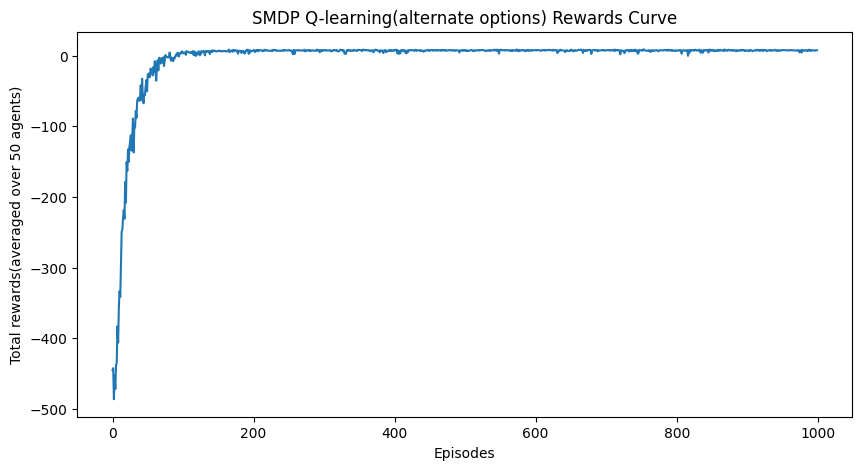

In [ ]:
# Plotting Rewards per Episode during Training(averaged over all the agents)
plot_reward_curve(smdp_modified_tuning_results["rewards_per_episode"], "SMDP Q-learning(alternate options) Rewards Curve")

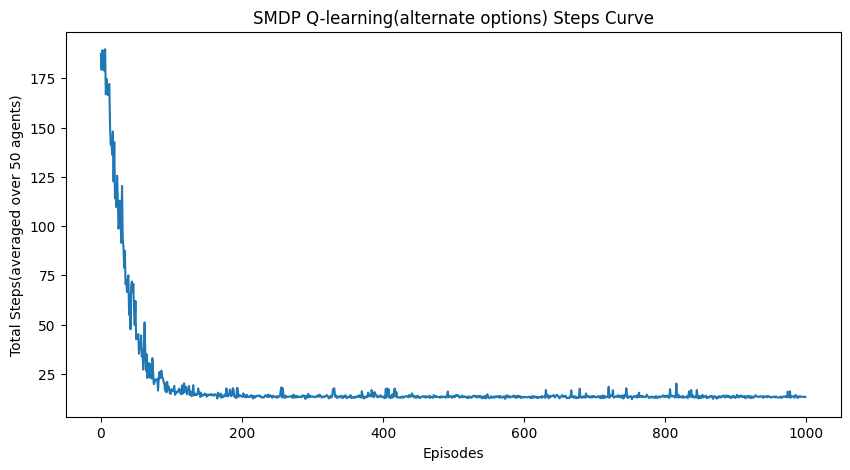

In [ ]:
# Plotting Steps per Episode during Training(averaged over all the agents)
plot_step_curve(smdp_modified_tuning_results["steps_per_episode"], "SMDP Q-learning(alternate options) Steps Curve")

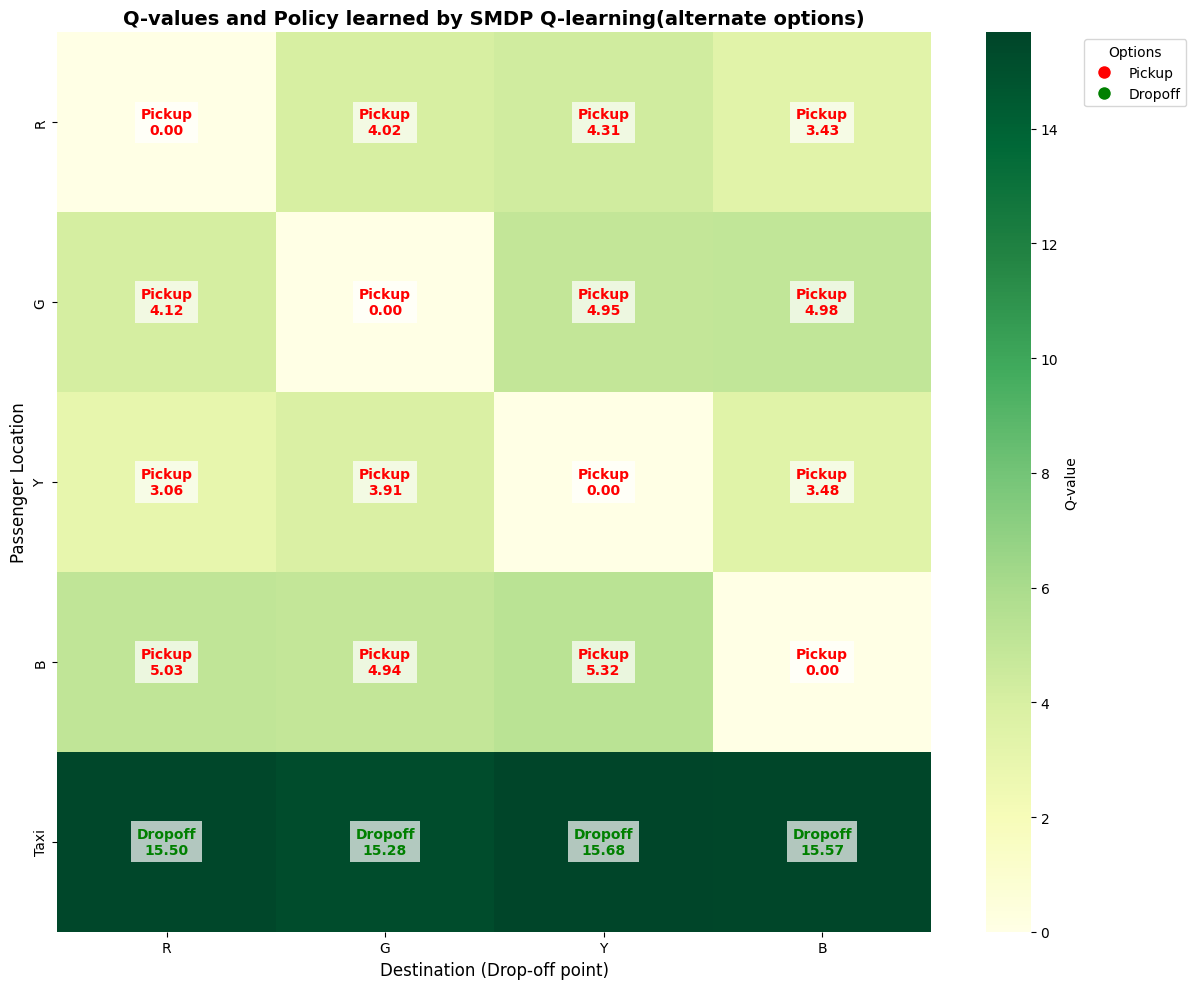

In [ ]:
# Plotting the Maximum Q-values After Training (averaged over all the agents)
visualize_overall_policy_modified(smdp_modified_tuning_results["Q"], "Q-values and Policy learned by SMDP Q-learning(alternate options)")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


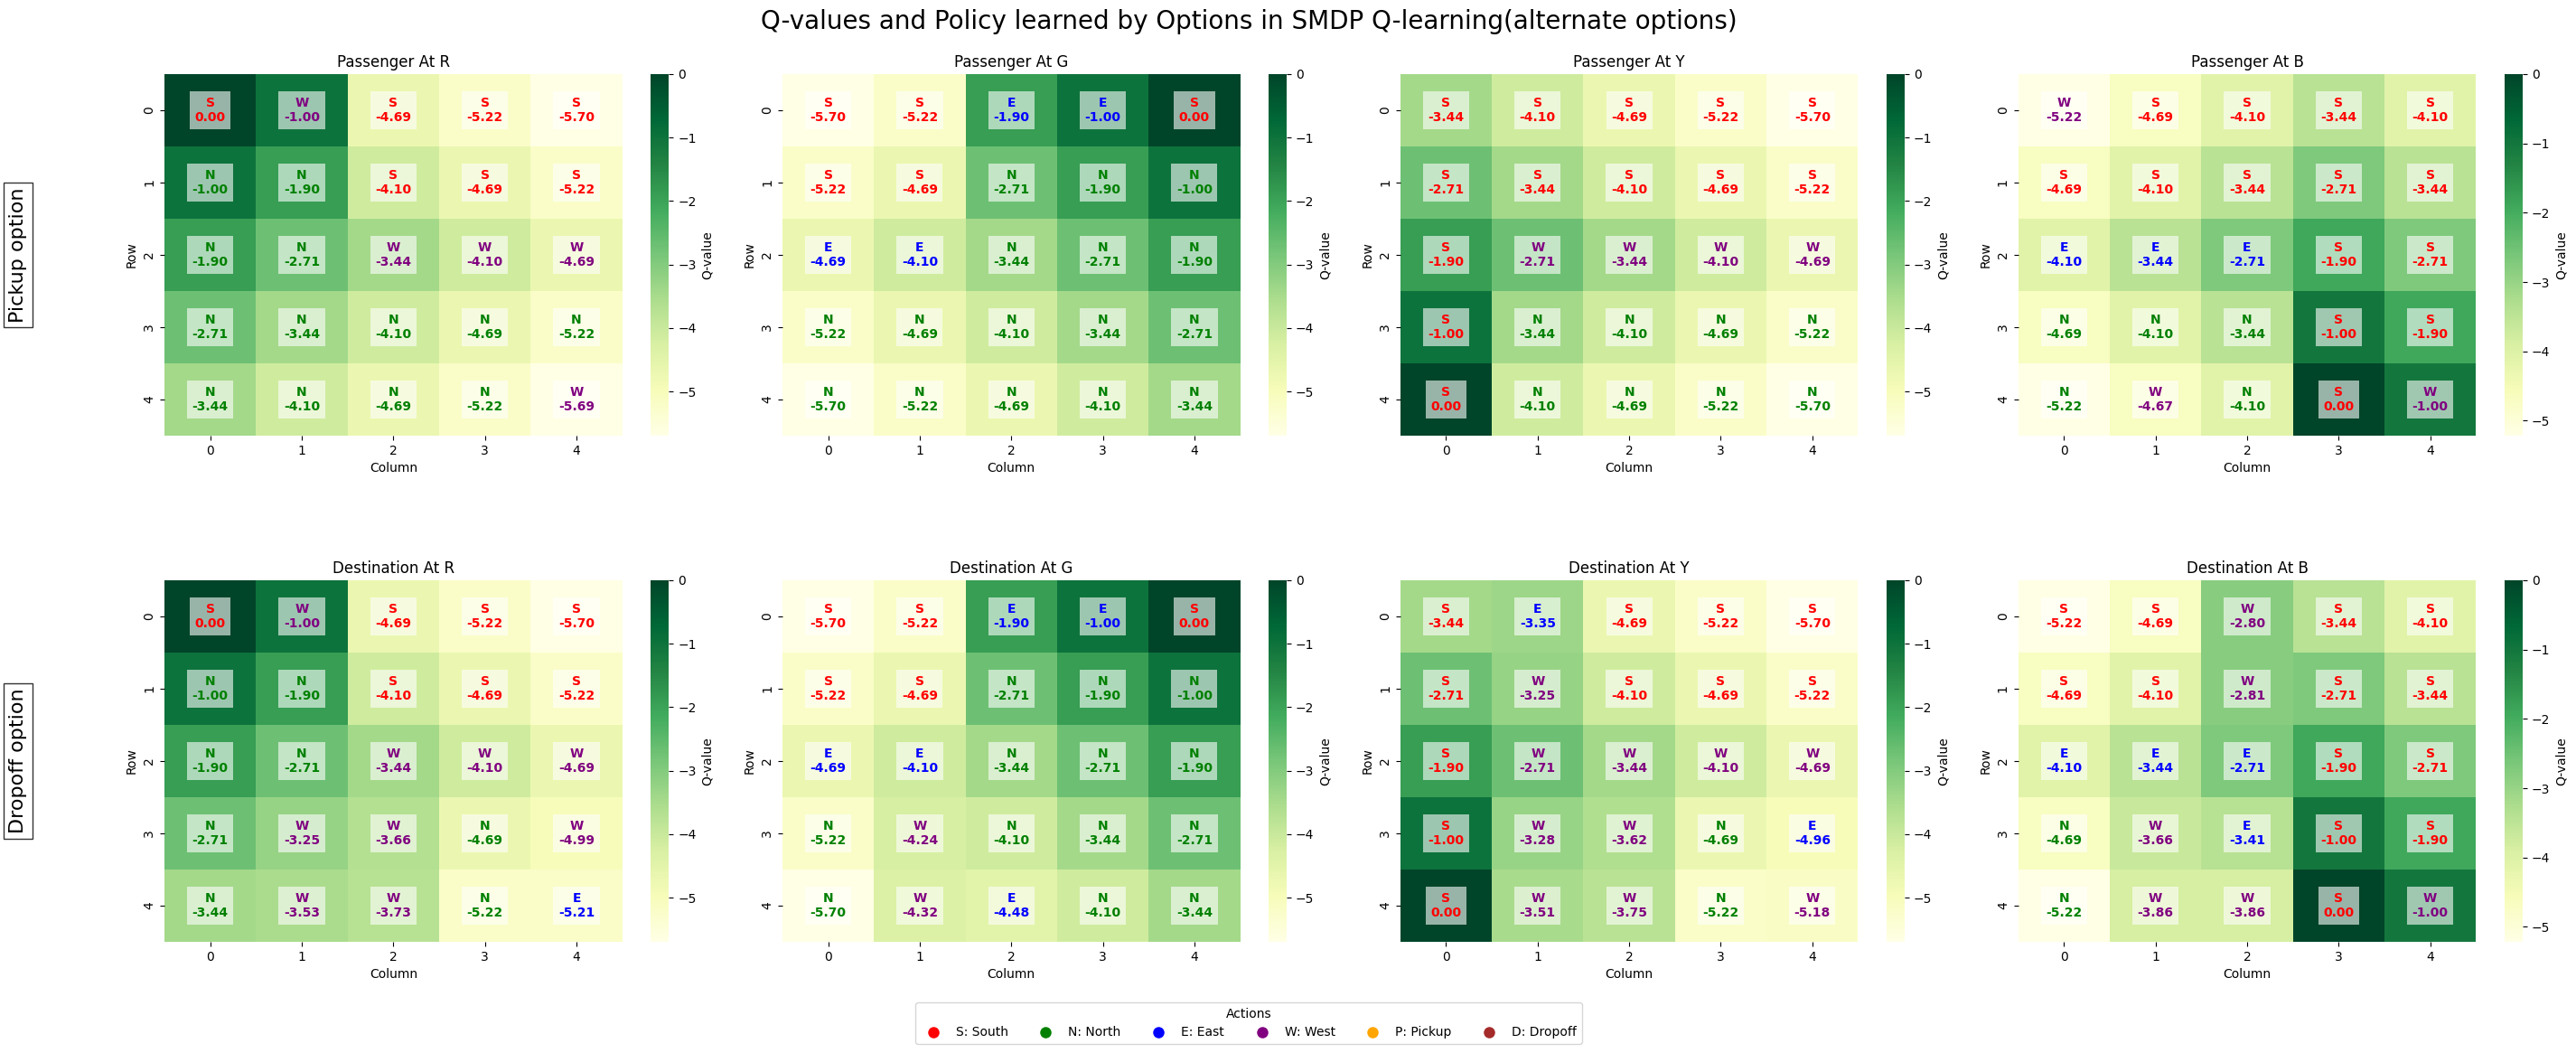

In [ ]:
# Plotting the Maximum Q-values of Each Option After Training (averaged over all the agents)
visualize_option_q_values_modified(smdp_modified_tuning_results["option_Q"], "Q-values and Policy learned by Options in SMDP Q-learning(alternate options)")

# Intra-option Q-Learning using alternate options

In [ ]:
def train_intra_option_q_learning_modified(hrl_obj, epsilon, learning_rate, num_episodes):
        """Train using Intra-Option Q-learning with alternate options."""
        episode_rewards = []
        ioql_steps = []

        # Initialize Q-values for intra-option learning
        intra_option_q_values = np.zeros((hrl_obj.num_passenger_states * hrl_obj.num_destinations, hrl_obj.num_options))

        # num_passenger_states is used for both the pickup and dropoff options to maintain the same number of states
        option_q_values = [np.zeros((hrl_obj.grid_size_x * hrl_obj.grid_size_y * hrl_obj.num_passenger_states, hrl_obj.num_actions))
            for _ in range(hrl_obj.num_options)
      ]

        for episode in range(num_episodes):
            state, _ = hrl_obj.env.reset()
            done = False
            total_reward = 0
            total_steps = 0

            while not done:
                # Choose option using epsilon-greedy
                substate = hrl_obj.get_substate_index(state)
                selected_option = hrl_obj.epsilon_greedy_policy(
                    intra_option_q_values, substate, epsilon
                )

                option_terminated = False

                while not option_terminated and not done:
                    # Get action from option policy
                    action, option_terminated = hrl_obj.execute_option(
                        state, selected_option, epsilon, option_q_values
                    )

                    # Execute action in environment
                    next_state, reward, terminated, truncated, _ = hrl_obj.env.step(action)
                    done = terminated or truncated
                    total_reward += reward
                    total_steps += 1

                    # Decode the state
                    old_x, old_y, old_pas, old_des = hrl_obj.env.unwrapped.decode(state)
                    new_x, new_y, new_pas, new_des = hrl_obj.env.unwrapped.decode(next_state)

                    # Calculate option's state
                    old_option_state = hrl_obj.grid_size_x * old_x + old_y
                    new_option_state = hrl_obj.grid_size_x * new_x + new_y

                    # Pickup option - only concern about the passenger's location
                    if selected_option == 0:
                      old_option_state = old_option_state * hrl_obj.grid_size_y + old_pas
                      new_option_state = new_option_state * hrl_obj.grid_size_y + new_pas
                    # Dropoff option - only concern about the destination's location
                    else:
                      old_option_state = old_option_state * hrl_obj.grid_size_y + old_des
                      new_option_state = new_option_state * hrl_obj.grid_size_y + new_des

                    # If the old_option_state is not a terminating position for the option, then update option policy's Q-values
                    if not option_terminated:
                      current_q = option_q_values[selected_option][old_option_state, action]
                      max_next_q = np.max(option_q_values[selected_option][new_option_state, :])
                      target = reward + hrl_obj.discount_factor *  max_next_q
                      option_q_values[selected_option][old_option_state, action] += learning_rate * (target - current_q)

                    # Update intra-option Q-values for all options that would have taken the same action
                    current_substate = hrl_obj.get_substate_index(state)
                    next_substate = hrl_obj.get_substate_index(next_state)

                    for option_idx in range(hrl_obj.num_options):
                        option_action, option_terminated_here = hrl_obj.execute_option(
                            state, option_idx, epsilon, option_q_values
                        )

                        # If the option_action is consistent with the action taken following the selected_option
                        if option_action == action or option_idx==selected_option:

                            current_q = intra_option_q_values[current_substate, option_idx]

                            if option_terminated_here:
                                # Option termination: bootstrap from best next option
                                max_next_q = np.max(intra_option_q_values[next_substate, :])
                                target = reward + hrl_obj.discount_factor * max_next_q

                            else:
                                # Option continuation: follow current option
                                next_q = intra_option_q_values[next_substate, option_idx]
                                target = reward + hrl_obj.discount_factor * next_q

                            intra_option_q_values[current_substate, option_idx] += learning_rate * (target - current_q)

                    state = next_state

            # Record episode results
            episode_rewards.append(total_reward)
            ioql_steps.append(total_steps)

        return episode_rewards, intra_option_q_values, ioql_steps, option_q_values

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Create tuner
tuner = HyperparameterTuner(num_agents=num_agents, num_episodes=1000, agent_class=ModifiedOptionsHRLAgent)

# Tune Intra-Option Q-learning with alternate options hyperparameters
print("Tuning hyperparameters for Intra-Option Q-learning with alternate options...")
ioql_modified_tuning_results = tuner.tune_hyperparameters(
    alpha_values, epsilon_values, method='ioql'
)
print(f'\nBest IOQL learning rate: {ioql_modified_tuning_results["learning_rate"]}')
print(f'Best IOQL Epsilon(exploration parameter): {ioql_modified_tuning_results["epsilon"]}')
print('Mean reward using best hyperparameters:', ioql_modified_tuning_results['mean_reward'])
print('Standard deviation of reward using best hyperparameters:', ioql_modified_tuning_results['std_reward'])

Tuning hyperparameters for Intra-Option Q-learning with alternate options...
Running 12 hyperparameter combinations on 4 processes...


Testing hyperparameters: 100%|██████████| 12/12 [20:11<00:00, 100.94s/it]


Best IOQL learning rate: 1
Best IOQL Epsilon(exploration parameter): 0.01
Mean reward using best hyperparameters: -3.745359999999999
Standard deviation of reward using best hyperparameters: 53.32594071997605


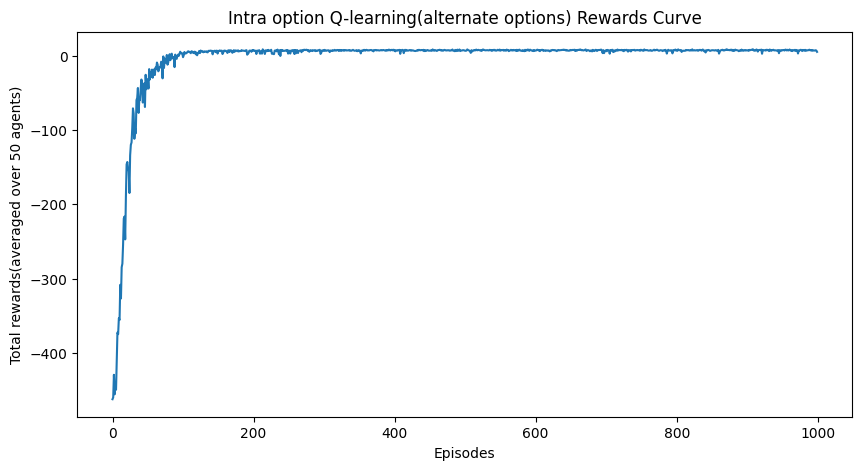

In [ ]:
# Plotting Rewards per Episode during Training(averaged over all the agents)
plot_reward_curve(ioql_modified_tuning_results["rewards_per_episode"], "Intra option Q-learning(alternate options) Rewards Curve")

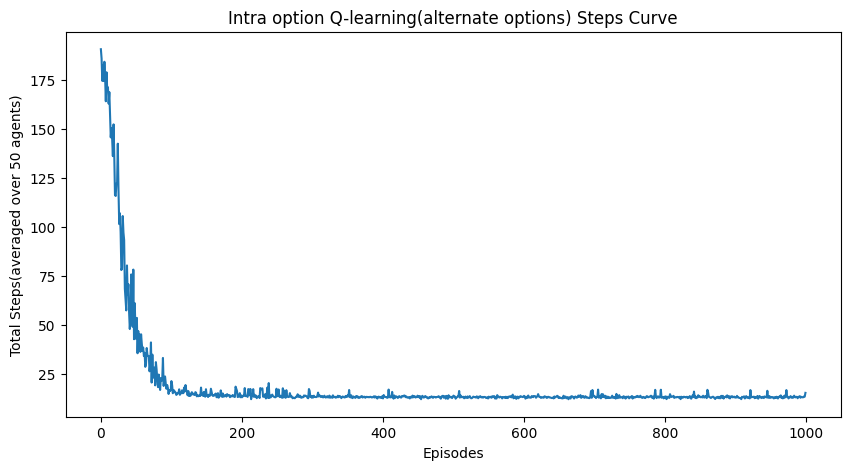

In [ ]:
# Plotting Steps per Episode during Training(averaged over all the agents)
plot_step_curve(ioql_modified_tuning_results["steps_per_episode"], "Intra option Q-learning(alternate options) Steps Curve")

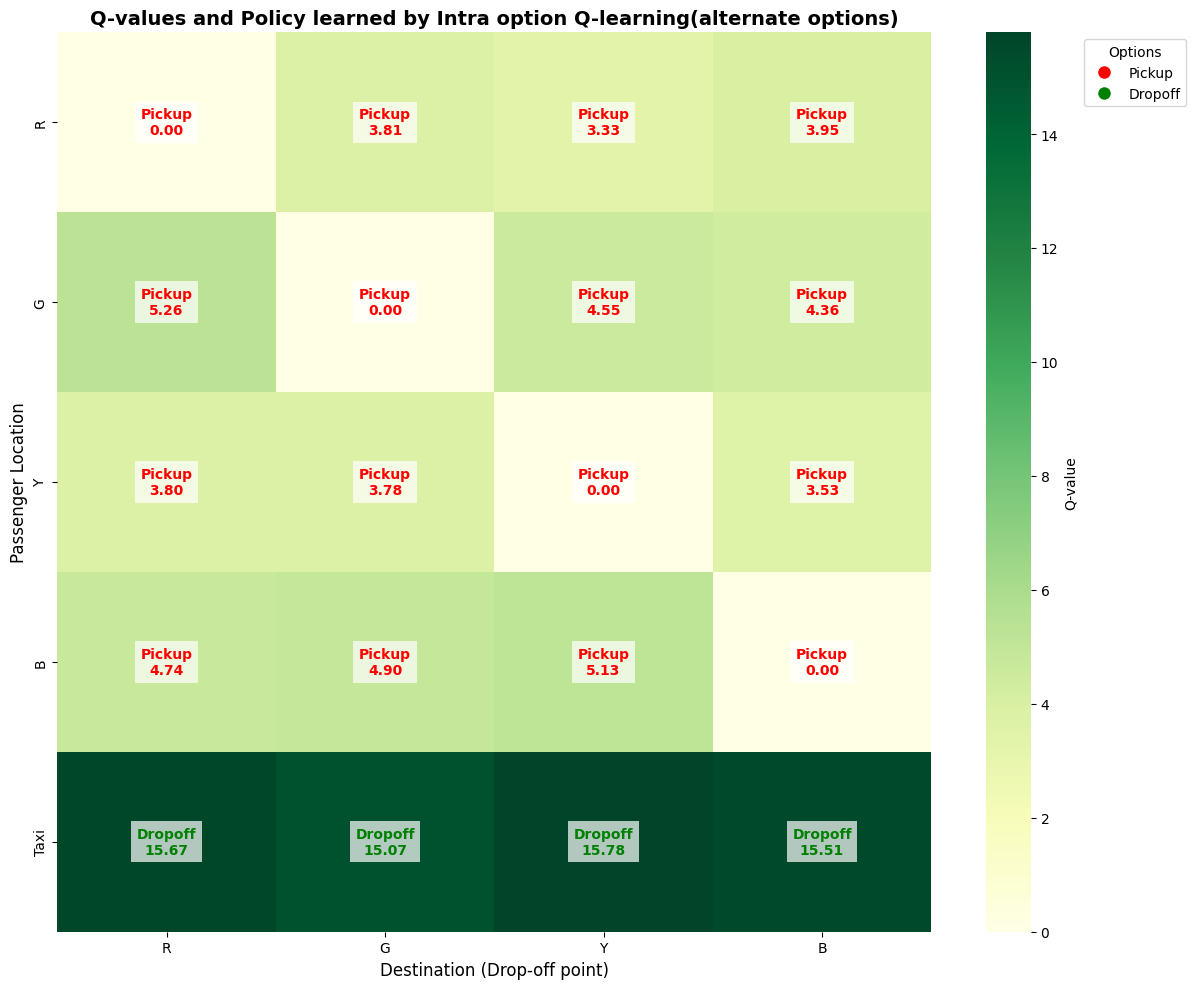

In [ ]:
# Plotting the Maximum Q-values After Training (averaged over all the agents)
visualize_overall_policy_modified(ioql_modified_tuning_results["Q"], "Q-values and Policy learned by Intra option Q-learning(alternate options)")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


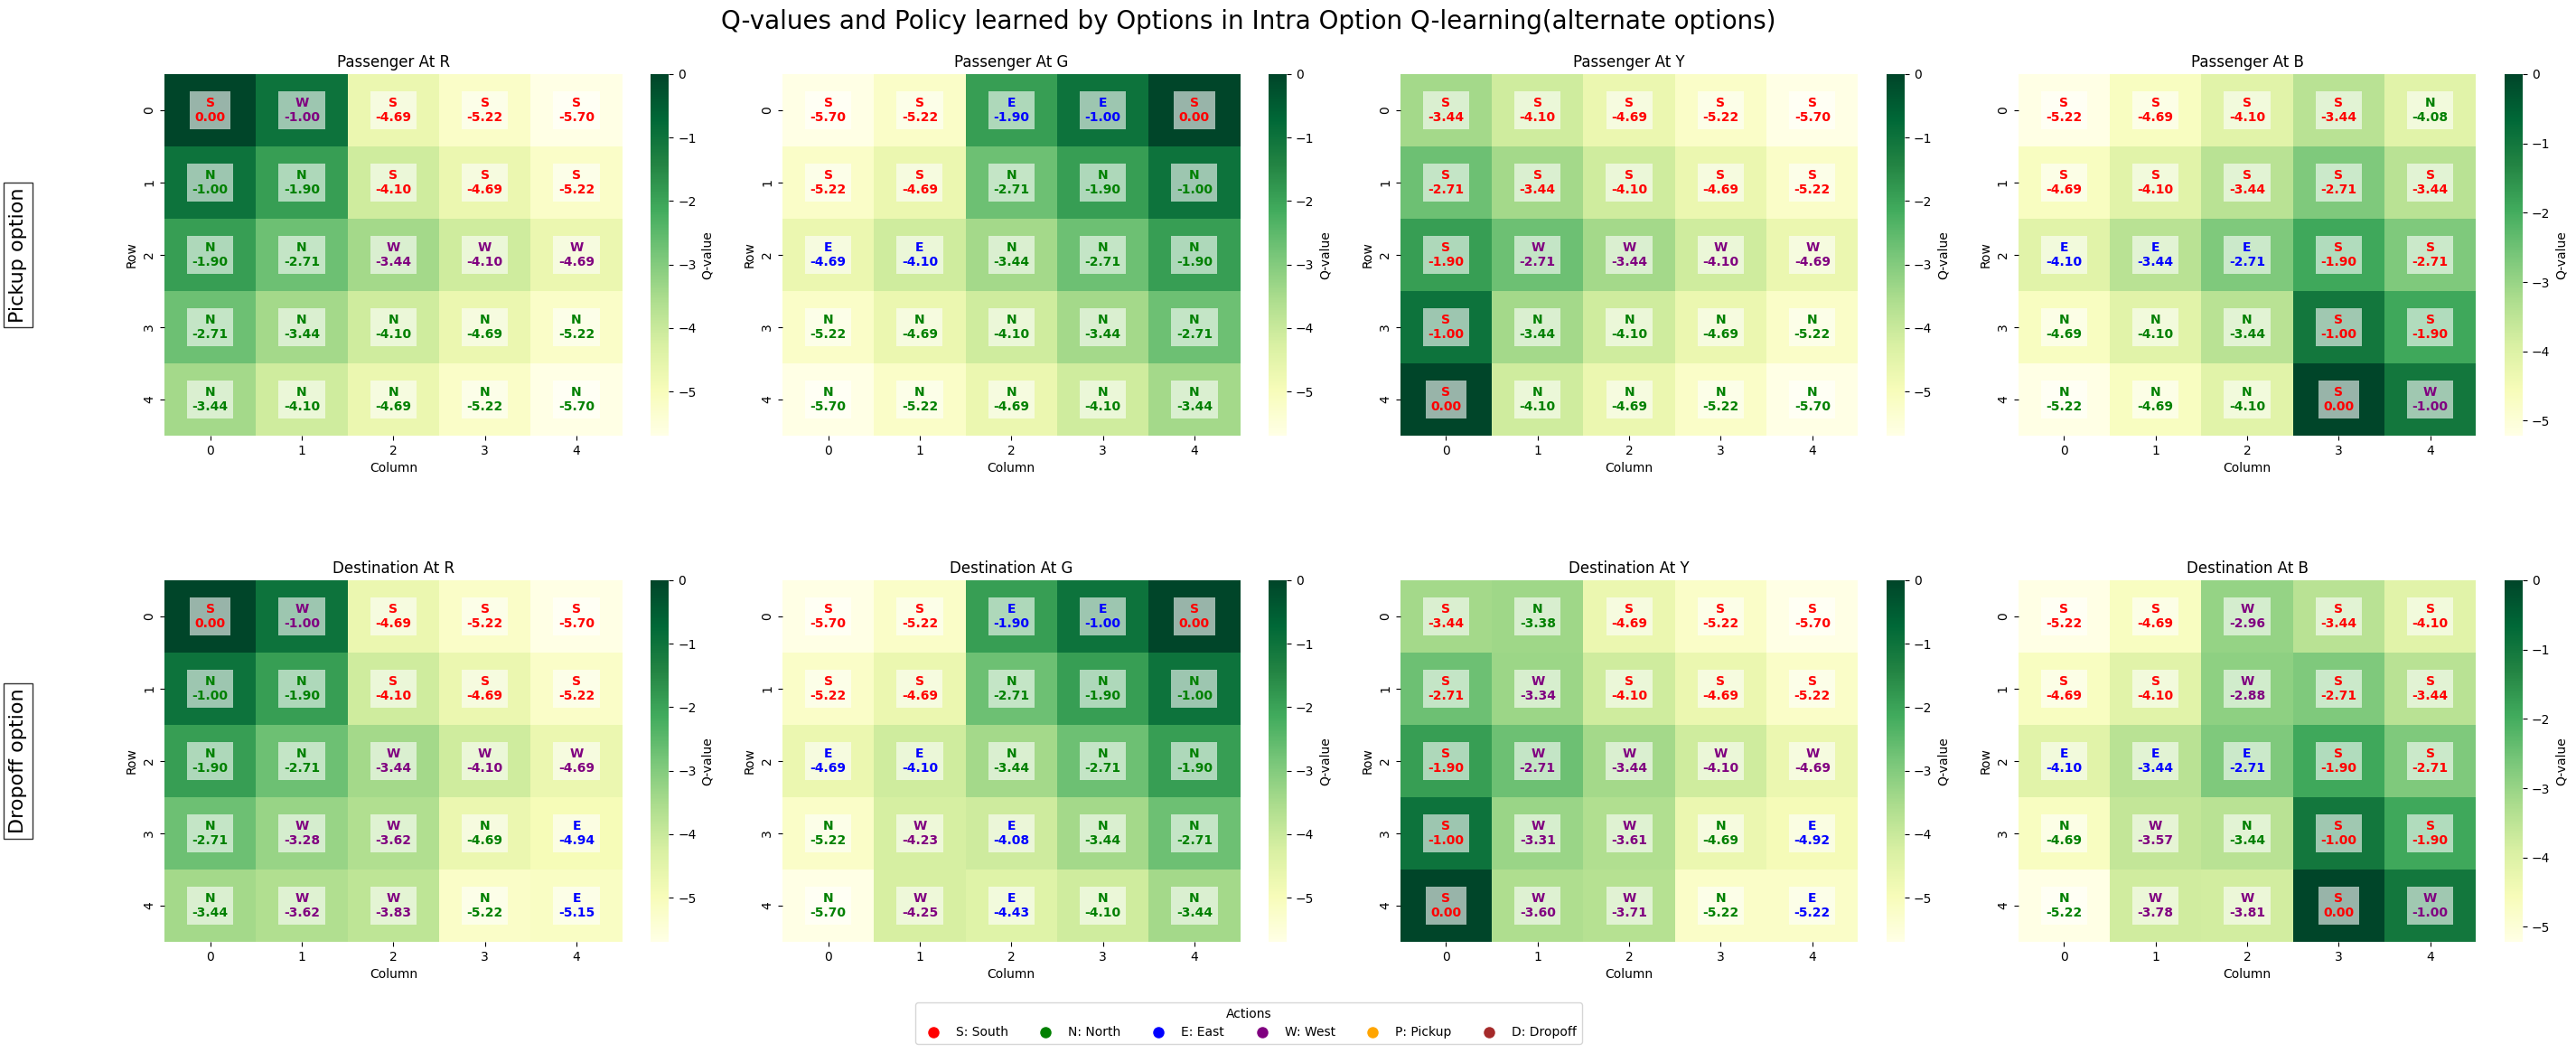

In [ ]:
# Plotting the Maximum Q-values of Each Option After Training (averaged over all the agents)
visualize_option_q_values_modified(ioql_modified_tuning_results["option_Q"], "Q-values and Policy learned by Options in Intra Option Q-learning(alternate options)")

# Comparison between algorithms learnt using given options and alternate options

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


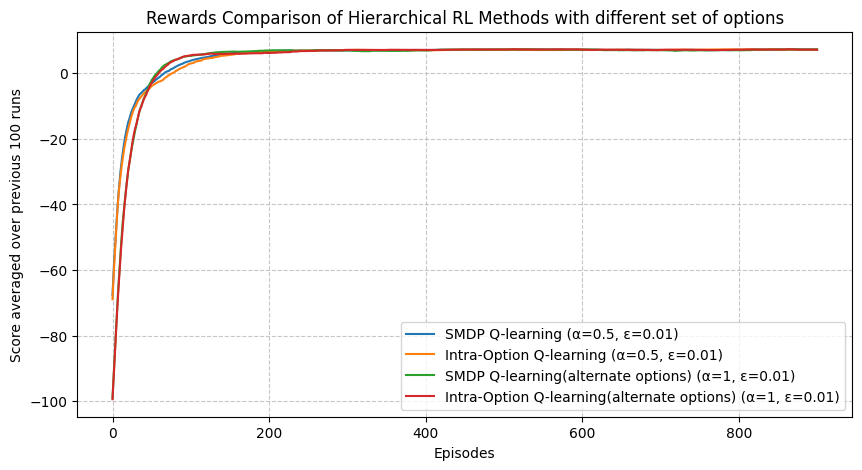

In [ ]:
results_dict = {"SMDP Q-learning": smdp_tuning_results, "Intra-Option Q-learning": ioql_tuning_results, "SMDP Q-learning(alternate options)": smdp_modified_tuning_results, "Intra-Option Q-learning(alternate options)": ioql_modified_tuning_results}
plot_reward_curves_comparison(results_dict, title="Rewards Comparison of Hierarchical RL Methods with different set of options")

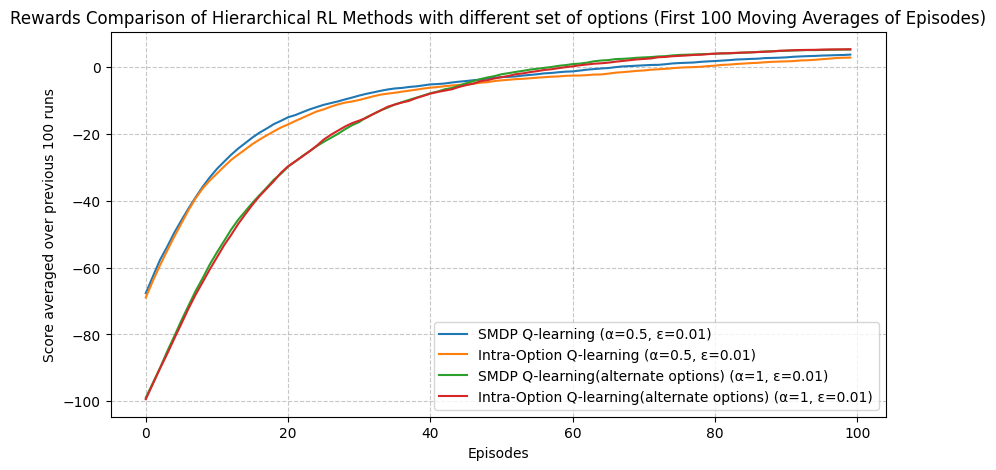

In [ ]:
plot_reward_curves_comparison(results_dict, episode_range="first_100", title="Rewards Comparison of Hierarchical RL Methods with different set of options (First 100 Moving Averages of Episodes)")

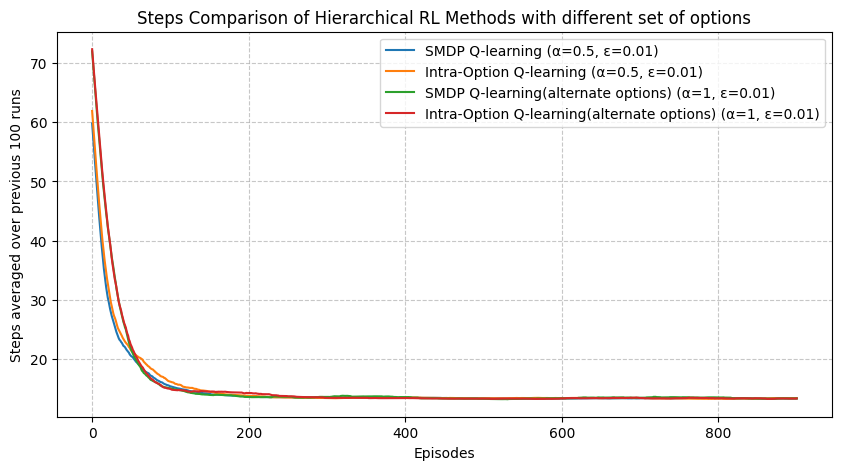

In [ ]:
plot_step_curves_comparison(results_dict, title="Steps Comparison of Hierarchical RL Methods with different set of options")

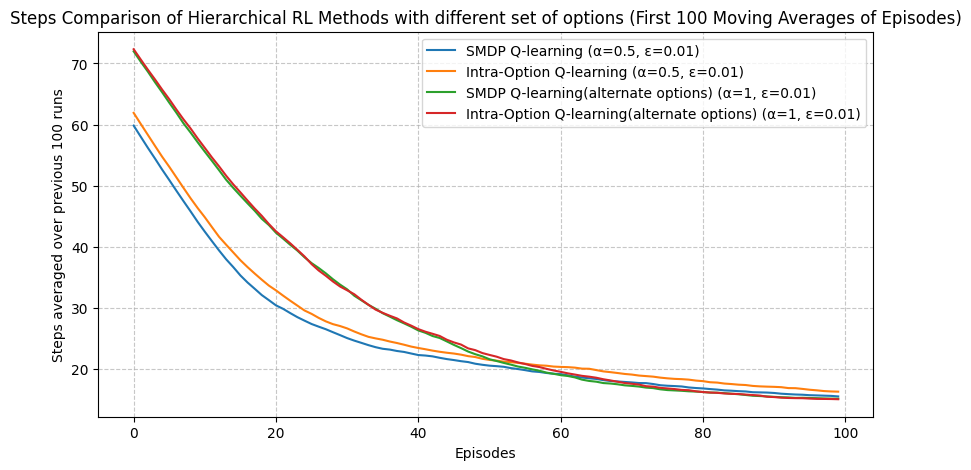

In [ ]:
plot_step_curves_comparison(results_dict, episode_range="first_100", title="Steps Comparison of Hierarchical RL Methods with different set of options (First 100 Moving Averages of Episodes)")